# Legal Intelligence Rank Monitor




This jupyter notebook provides the prototype of the rank monitor:

It should:

- Request queries, clicks and their corresponding position on the query list
- Pre-process the data into readable format
- Calculate the NDCG
- Be able to re-run queries, with appropriate access rights and re-calculate the nDCG


### Basic Utilities for python

In [74]:
import numpy as np
from sklearn.metrics import f1_score, average_precision_score
import math
import requests
import os

from urllib import *
import json

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from collections import Counter
from tqdm import tqdm_notebook as tqdm
tqdm_notebook().pandas()


# Greedy IDE completion 
%config IPCompleter.greedy=True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [72]:
# Activate Jupyter %%javascript magic
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

### Javascript for a duplicate line on Ctrl-Shift-d

In [6]:
%%js

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('Ctrl-Shift-a', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);


<IPython.core.display.Javascript object>

### DCG function

Implementation for the discounted cumulative gain (DCG) function.


$$ \mathrm{DCG_{p}} = \sum_{i=1}^{N} \frac{rel_{i}}{\log_{b}(i+1)} = rel_1 + \sum_{i=2}^{N} \frac{rel_{i}}{\log_{b}(i+1)}  $$

Mean average precision (MAP) and F1 scores are only defined for binary relevance scores.



In [7]:
y_true = np.array([3, 2, 3, 0, 0, 1, 2, 2, 3, 0])
print(y_true.shape)

def dcg(y_true: np.array, log_base: 2):
    """
    Returns ndcg given the truth values (clicks) for a given query
    :param y_true: np.array of clicked documents in order
    :param log_base: the log discount factor
    :return:
    """
    gain = y_true[0]
    for index, rel_i in enumerate(y_true):
        if index !=0:
            gain += rel_i / (math.log(rel_i+index+1, log_base))

    return gain

MAP  = []
NDCG = []
F1   = []

for i in range(1,11):
#     MAP.append(average_precision_score(y_true[0:i],y_pred[0:i]))
    NDCG.append(dcg(y_true[0:i],log_base=2))
#     F1.append(f1_score(y_true[0:i], y_pred[0:i]))

# print("MAP : ", MAP[-1])
print("NDCG : ", NDCG[-1])
# print("F1: ", F1[-1])




(10,)
NDCG :  7.586584190664457


In [5]:
def make_solr_request(rows= 100, query= '*:*'):
    """
    :param rows: amount of rows to request
    :param query: string to query
    """
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
    '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&start=0&wt=json'.format(query,rows)

    return url
    
print(make_solr_request())


http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?indent=on&q=*:*&rows=100&start=0&wt=json


In [12]:
currentdir = Path('./data/')
[file for file in currentdir.glob('*')]


[PosixPath('data/EventID:164 AND UserID:155729 AND Year:2019.hdf'),
 PosixPath('data/EventID:164 AND UserID:113223 AND Year:2019.hdf'),
 PosixPath('data/EventID:27 AND UserID:155729 AND Year:2019.hdf'),
 PosixPath('data/EventID:27 AND UserID:113223 AND Year:2019.hdf'),
 PosixPath('data/EventID:27Full2019.hdf'),
 PosixPath('data/EventID:164Full2019.hdf')]

### Normal search: EventID:164 AND SearchTypeID:1

**EventID:164** : Perform search: This event is logged whensearch action is performed with LI web
application. The event logs search specific data like, searchtext, totalresults found for search, filterpath and anonymous user code.


**SearchTypeID:1** : respresents search performed from basic search


Longests query in set: recital 74 in cases where an investment firm is required "to" provide information "to" a client before the provision of a service, each transaction in respect of the same type of financial instrument should not be considered as the provision of a new service


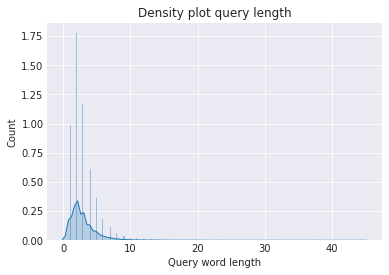

AnonymizedUserCode  AppID  CompID Department  \
0  58-47-8A-96-2F-2B-B7-E6-14-4B-42-21-67-C4-F2-80      1     NaN        NaN   
1  7A-32-02-60-17-5A-21-93-6E-79-AD-0E-BB-00-F4-B3      1     NaN        NaN   
2  58-7C-9A-FA-73-70-4D-63-83-9E-54-74-CC-B2-3F-A7      1     NaN        NaN   
3  47-2B-DA-D9-19-6B-21-3A-F3-66-98-DD-FD-C7-45-F7      1     NaN        NaN   
4  58-7C-9A-FA-73-70-4D-63-83-9E-54-74-CC-B2-3F-A7      1     NaN        NaN   

   EventID              FilterPath FunctionArea  \
0      164                       /          NaN   
1      164  /Nederland/Rechtspraak          NaN   
2      164                       /          NaN   
3      164                       /          NaN   
4      164                       /          NaN   

                                     ID  Month  Quarter  \
0  7a1459b4-82d3-4e63-bb9f-832d1e92920d     12        4   
1  d2fa138e-fb6f-4510-bc13-3f39c785938d     12        4   
2  8f1eb01f-7f36-44ac-827d-f73379b82154     12        4   
3  71d71f1b-c1ae-4d3c-babc-f43d44b5d073     12        4   
4  15a9d72b-89f0-4b41-b096-8f7a61e35f1f     12        4   

                    SearchText  SearchTypeID  ShortTimeStamp  SiteID  \
0                  robo advice             1        20161221       1   
1  stage + opvolgend werkgever             1        20161221       1   
2        afwijkend peil woning             1        20161221       1   
3               rijbewijs kart             1        20161221       1   
4        afwijkend peil woning             1        20161221       1   

                  TimeStamp  TotalResult  UserID  Week  Year  \
0  2016-12-21T15:13:10.283Z           23     NaN    52  2016   
1  2016-12-21T15:13:14.094Z            6     NaN    52  2016   
2  2016-12-21T15:13:02.240Z         9908     NaN    52  2016   
3  2016-12-21T15:13:06.784Z           53     NaN    52  2016   
4  2016-12-21T15:13:07.558Z          106     NaN    52  2016   

             _version_  
0  1554339089634820103  
1  1554339093844852742  
2  1554339079116554252  
3  1554339081215803401  
4  1554339083325538316

In [11]:
# response = pd.read_json('data/mock100.json')

url = make_solr_request(rows=10000, query='EventID:164 AND SearchTypeID:1')
response = requests.get(url)

# Make the requests into a json
response = response.json()


# response = pd.read_json('data/mock100.json')


response = response['response']['docs'][1:]
# print(response)
df =  pd.DataFrame(response)
df.head()


text = df['SearchText'].tolist()

number = [len(sentence.split()) for sentence in text]

# Longest Query in the set
print("Longests query in set:", text[np.argmax(number)])

num_words = [len(sentence.split()) for sentence in text if sentence != '']

sns.distplot(num_words, hist=True, kde=True, 
             bins='auto',  
             kde_kws={'linewidth': 1, 'shade':True},
             norm_hist=False)
plt.xlabel('Query word length')
plt.ylabel('Count')
plt.title("Density plot query length")
plt.show()


df.head()


### Query Reformulation EventID:164 AND SearchTypeID:1


## use Plotly

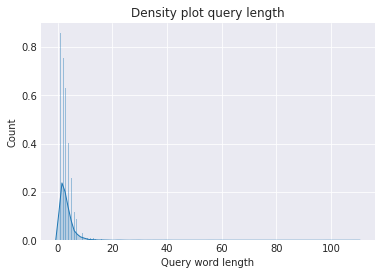

AnonymizedUserCode  AppID  CompID Department  \
0  85-B6-EC-64-0E-52-00-61-C7-77-89-88-B5-5F-02-68      1     NaN        NaN   
1  85-B6-EC-64-0E-52-00-61-C7-77-89-88-B5-5F-02-68      1     NaN        NaN   
2  85-B6-EC-64-0E-52-00-61-C7-77-89-88-B5-5F-02-68      1     NaN        NaN   
3  6E-B1-9C-1E-7E-C3-7A-AB-0A-99-A0-83-06-52-84-65      1     NaN        NaN   
4  1B-65-FB-AA-35-7C-86-85-4D-A8-A7-19-79-5C-04-C9      1     NaN        NaN   

   EventID                                         FilterPath  \
0      164                          /Literatuur/Tijdschriften   
1      164  /Literatuur/Rechtspraak, Literatuur/Tijdschrif...   
2      164  /Literatuur/Rechtspraak, Literatuur/Tijdschrif...   
3      164                                                  /   
4      164                                                  /   

                                     ID  Month  Quarter  \
0  f86a812d-73cb-46fc-a510-2be71f62c766     12        4   
1  f563f0ec-8f8c-4374-a241-d52d85e5f7da     12        4   
2  97810c33-2c3f-418e-87c2-6eda385b81c3     12        4   
3  31ab65b1-69ae-44c8-85d7-62f19a16de42     12        4   
4  f6342893-8e22-4622-856d-f1bb10dadad4     12        4   

                                        SearchText  SearchTypeID  \
0  verzet AND kort-geding AND verstek AND "143 rv"            22   
1               verzet AND kort-geding AND verstek            22   
2                           verzet AND kort-geding            22   
3                   vergunning van rechtswege awb             22   
4                            Buitenland contractor            22   

   ShortTimeStamp  SiteID                 TimeStamp  TotalResult  UserID  \
0        20161221       1  2016-12-21T15:28:44.636Z           81     NaN   
1        20161221       1  2016-12-21T15:24:53.774Z            2     NaN   
2        20161221       1  2016-12-21T15:23:26.081Z           87     NaN   
3        20161221       1  2016-12-21T15:29:58.699Z        14252     NaN   
4        20161221       1  2016-12-21T15:27:01.451Z          595     NaN   

   Week  Year            _version_  
0    52  2016  1554340119191748608  
1    52  2016  1554339765796470784  
2    52  2016  1554339770131283968  
3    52  2016  1554340071644069890  
4    52  2016  1554340046657552394

In [12]:
# response = pd.read_json('data/mock100.json')

url = make_solr_request(rows=10000, query='EventID:164 AND SearchTypeID:22')
response = requests.get(url)

# Make the requests into a json
response = response.json()


response = response['response']['docs'][1:]
# print(response)
df =  pd.DataFrame(response)
df.head()


text = df['SearchText'].tolist()
num_words = [len(sentence.split()) for sentence in text if sentence != '' and str(sentence) != 'nan']

sns.distplot(num_words, hist=True, kde=True, 
             bins='auto',  
             kde_kws={'linewidth': 1, 'shade':True},
             norm_hist=False)
plt.xlabel('Query word length')
plt.ylabel('Count')
plt.title("Density plot query length")
plt.show()

df.head()


### SearchSession ID EventID:164&27 AND UserID:113223


**EventID:164** : Perform Search
**EventID:27** : Perform Search

In [13]:
url = make_solr_request(rows=1000000, query='EventID:164 AND UserID:113223 AND Year:2019')
response = requests.get(url)
response = response.json()
response = response['response']['docs'][1:]
# print(response)
df =  pd.DataFrame(response)
# df.head()
print(len(df))
print(df.info())

df.to_hdf('./data/EventID:164 AND UserID:113223 AND Year:2019.hdf', key='test', mode='w')

url = make_solr_request(rows=1000000, query='EventID:27 AND UserID:113223 AND Year:2019')
response = requests.get(url)
response = response.json()
response = response['response']['docs'][1:]
# print(response)
df =  pd.DataFrame(response)
# df.head()
print(len(df))
print(df.info())

df.to_hdf('./data/EventID:27 AND UserID:113223 AND Year:2019.hdf', key='test', mode='w')


273
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 17 columns):
AppID             273 non-null int64
CompID            273 non-null int64
EventID           273 non-null int64
FilterPath        98 non-null object
ID                273 non-null object
Month             273 non-null int64
Quarter           273 non-null int64
SearchText        191 non-null object
SearchTypeID      273 non-null int64
ShortTimeStamp    273 non-null int64
SiteID            273 non-null int64
TimeStamp         273 non-null object
TotalResult       273 non-null int64
UserID            273 non-null int64
Week              273 non-null int64
Year              273 non-null int64
_version_         273 non-null int64
dtypes: int64(13), object(4)
memory usage: 36.3+ KB
None


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2378: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['FilterPath', 'ID', 'SearchText', 'TimeStamp']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


219
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 19 columns):
AppID               219 non-null int64
CompID              219 non-null int64
DocumentID          219 non-null object
DocumentPosition    135 non-null float64
DocumentSource      219 non-null object
DocumentURL         219 non-null object
EventID             219 non-null int64
ID                  219 non-null object
Month               219 non-null int64
Publisher           219 non-null object
Quarter             219 non-null int64
SearchTypeID        178 non-null float64
ShortTimeStamp      219 non-null int64
SiteID              219 non-null int64
TimeStamp           219 non-null object
UserID              219 non-null int64
Week                219 non-null int64
Year                219 non-null int64
_version_           219 non-null int64
dtypes: float64(2), int64(11), object(6)
memory usage: 32.6+ KB
None


### SearchSession ID EventID:164&27 AND UserID:155729


**EventID:164** : Perform Search 
<br>
**EventID:27** : Perform Search

In [14]:
url = make_solr_request(rows=1000000, query='EventID:164 AND UserID:155729 AND Year:2019')
response = requests.get(url)
response = response.json()
response = response['response']['docs'][1:]
# print(response)
df =  pd.DataFrame(response)
# df.head()
print(len(df))
print(df.info())

df.to_hdf('./data/EventID:164 AND UserID:155729 AND Year:2019.hdf', key='test', mode='w')

url = make_solr_request(rows=1000000, query='EventID:27 AND UserID:155729 AND Year:2019')
response = requests.get(url)
response = response.json()
response = response['response']['docs'][1:]
# print(response)
df =  pd.DataFrame(response)
# df.head()
print(len(df))
print(df.info())

df.to_hdf('./data/EventID:27 AND UserID:155729 AND Year:2019.hdf', key='test', mode='w')


136
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 17 columns):
AppID             136 non-null int64
CompID            136 non-null int64
EventID           136 non-null int64
FilterPath        67 non-null object
ID                136 non-null object
Month             136 non-null int64
Quarter           136 non-null int64
SearchText        99 non-null object
SearchTypeID      136 non-null int64
ShortTimeStamp    136 non-null int64
SiteID            136 non-null int64
TimeStamp         136 non-null object
TotalResult       136 non-null int64
UserID            136 non-null int64
Week              136 non-null int64
Year              136 non-null int64
_version_         136 non-null int64
dtypes: int64(13), object(4)
memory usage: 18.1+ KB
None


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2378: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['FilterPath', 'ID', 'SearchText', 'TimeStamp']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


128
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 19 columns):
AppID               128 non-null int64
CompID              128 non-null int64
DocumentID          126 non-null object
DocumentPosition    92 non-null float64
DocumentSource      128 non-null object
DocumentURL         128 non-null object
EventID             128 non-null int64
ID                  128 non-null object
Month               128 non-null int64
Publisher           128 non-null object
Quarter             128 non-null int64
SearchTypeID        117 non-null float64
ShortTimeStamp      128 non-null int64
SiteID              128 non-null int64
TimeStamp           128 non-null object
UserID              128 non-null int64
Week                128 non-null int64
Year                128 non-null int64
_version_           128 non-null int64
dtypes: float64(2), int64(11), object(6)
memory usage: 19.1+ KB
None


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2378: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['DocumentID', 'DocumentSource', 'DocumentURL', 'ID', 'Publisher', 'TimeStamp']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


#### DCG for one user

Hoe kan dit ? 

df_27 = pd.read_hdf(path_or_buf='./data/EventID:27 AND UserID:155729 AND Year:2019.hdf')
df_164 = pd.read_hdf(path_or_buf='./data/EventID:164 AND UserID:155729 AND Year:2019.hdf')

\#Only get the columns
cols_to_use = df_164.columns.difference(df_27.columns)

### Wat gebeurd hier precies 
df = pd.merge(df_27, df_164[cols_to_use],  left_index=True, right_index=True, how='outer')

print(list(df))
### print(df.head())

df = df.drop(labels=['SiteID', 'Publisher', '_version_', 'AppID', 'DocumentSource', 'Month', 'Publisher', 'ID', 'Week', 'Year', 'FilterPath', 'Quarter'], axis=1)
df = df.dropna()

df

ROW : 10	379.0	31008201	46.0	https://www.navigator.nl/#/document/idpass3b5f...	27.0	14.0	20190124.0	2019-01-24T08:32:23.860Z	155729.0	ecli:NL:GHSHE:2014:2777	8

In [111]:
df_27 = pd.read_hdf(path_or_buf='./data/EventID:27 AND UserID:155729 AND Year:2019.hdf')
df_164 = pd.read_hdf(path_or_buf='./data/EventID:164 AND UserID:155729 AND Year:2019.hdf')

print(list(df_164))
print(list(df_27))

print(len(df_164))
print(len(df_27))

# Only get the columns
cols_to_use = df_164.columns.difference(df_27.columns)
# Wat gebeurd hier precies 
df = pd.merge(df_27, df_164[cols_to_use],  left_index=True, right_index=True, how='outer')


df = df.drop(labels=['SiteID', 'Publisher', '_version_', 'AppID', 'DocumentSource', 'Month', 'Publisher', 'ID', 'Week', 'Year', 'FilterPath', 'Quarter'], axis=1)
df = df.dropna()

df

# edge_case = df[df['DocumentPosition'] > df['TotalResult']]


that_data_frame = df.groupby(['SearchText'])
that_data_frame.head()



['AppID', 'CompID', 'EventID', 'FilterPath', 'ID', 'Month', 'Quarter', 'SearchText', 'SearchTypeID', 'ShortTimeStamp', 'SiteID', 'TimeStamp', 'TotalResult', 'UserID', 'Week', 'Year', '_version_']
['AppID', 'CompID', 'DocumentID', 'DocumentPosition', 'DocumentSource', 'DocumentURL', 'EventID', 'ID', 'Month', 'Publisher', 'Quarter', 'SearchTypeID', 'ShortTimeStamp', 'SiteID', 'TimeStamp', 'UserID', 'Week', 'Year', '_version_']
136
128


CompID DocumentID  DocumentPosition  \
0     379.0    5425621               2.0   
1     379.0    2554325               1.0   
2     379.0   13684929               6.0   
3     379.0   14482907               3.0   
4     379.0    3911880               4.0   
5     379.0   14684289               1.0   
6     379.0   23126592               7.0   
7     379.0   14276493               8.0   
9     379.0   14684289               2.0   
10    379.0   31008201              46.0   
11    379.0   31003727              54.0   
13    379.0    6470217              11.0   
14    379.0   31169305              16.0   
15    379.0   31259473              31.0   
16    379.0   31061373              43.0   
21    379.0   30250312               1.0   
22    379.0   30250312               1.0   
24    379.0   27927094               2.0   
26    379.0   28554081               4.0   
27    379.0    3852655               7.0   
28    379.0    3852655               7.0   
29    379.0    4587301              12.0   
30    379.0   28554081              21.0   
31    379.0   30230798              22.0   
34    379.0    4581522               3.0   
35    379.0   30250312               1.0   
36    379.0    3996193               4.0   
38    379.0   30250312               1.0   
40    379.0   30230798               1.0   
41    379.0    3775905               1.0   
..      ...        ...               ...   
48    379.0   30580477               8.0   
50    379.0    4396135               1.0   
51    379.0   27731034               4.0   
52    379.0   24806883               5.0   
53    379.0   31226685               1.0   
55    379.0    4332640               6.0   
56    379.0    4447122               1.0   
57    379.0    3997893              13.0   
62    379.0   31003729               3.0   
65    379.0   31160860               3.0   
67    379.0   31061434               2.0   
68    379.0   31058084               1.0   
83    379.0    4349568               3.0   
85    379.0    6768723               1.0   
87    379.0    6936967               7.0   
90    379.0   31275788               3.0   
91    379.0   27285554               6.0   
92    379.0   24207472               8.0   
93    379.0    3995598              11.0   
95    379.0   24806883              11.0   
96    379.0   12661502               5.0   
98    379.0    8830417              33.0   
101   379.0    4245720               4.0   
102   379.0    3747846               2.0   
104   379.0   15543833               1.0   
106   379.0    3996272               5.0   
107   379.0   31580673               3.0   
109   379.0   31574058               3.0   
110   379.0   31470762               6.0   
124   379.0   15166554               1.0   

                                           DocumentURL  EventID  SearchTypeID  \
0    https://www.navigator.nl/#/document/id2e7dae22...     27.0          14.0   
1    https://eur-lex.europa.eu/legal-content/NL/TXT...     27.0          14.0   
2    http://www.legalintelligence.com/documents/loc...     27.0          14.0   
3    https://www.navigator.nl/#/document/idaedb83d0...     27.0          14.0   
4    http://www.legalintelligence.com/documents/loc...     27.0          14.0   
5    https://www.navigator.nl/#/document/idc89aaf14...     27.0          14.0   
6    https://www.navigator.nl/#/document/id4eca56cd...     27.0          14.0   
7    https://www.navigator.nl/#/document/id87597cd6...     27.0          14.0   
9    https://www.navigator.nl/#/document/idc89aaf14...     27.0          14.0   
10   https://www.navigator.nl/#/document/idpass3b5f...     27.0          14.0   
11   https://www.navigator.nl/#/document/id1bc358b1...     27.0          14.0   
13                http://www.ndfr.nl/link/AP2006-01-04     27.0          14.0   
14   https://www.navigator.nl/#/document/idpass0e00...     27.0          14.0   
15   http://www.bjutijdschriften.nl/tijdschrift/con...     27.0          14.0   
16   http://www.legalintelligence.com/documents/loc...     27

In [16]:
dat_list = df.values.tolist()
queries = list(set([element[9] for element in dat_list]))

total =  {}
for query in queries:
    total.update({query : []})
    for element in dat_list:
        if query == element[9]:
            total[query].append(int(element[2]))
            
print(total)

{'bescherming minderheidsaandeelhouder BV': [1, 1], 'klantenbestand overdracht AVG': [1], 'Assink & Slagter 2013, p. 1805': [4], 'uitzendrichtlijn': [2], 'leaderland': [3, 1], 'Afdeling rechtspraak van de raad van state': [8], 'vennootschappelijk belang': [6], 'lauderman': [4, 1], 'vennootschapsbelang': [4, 2, 1], 'vennootschapsrechtelijk belang': [5], 'pandlijst 3:239 BW levering': [3, 3], 'NJ 2006/443': [8], 'wet opheffing verpandingsverbooden': [2], 'artikel 245 RV ontbinding': [4, 5], 'bescherming minderheidsaandeelhouder': [43], 'vennootschappelijk belang ': [5], 'leaderland 2:354 BW': [7], '2:354 BW overkleeft': [1], 'artikel 47 Fw registreren pandlijst': [3], 'werknemers  vs uitzendkrachten': [3], 'raaijmakers persoonsvennootschappen': [33], 'artikel 47 fw pandrecht': [1, 13], 'HR 4 februari 2005': [11], '2:354 BW': [1, 3], 'ECLI:NL:RBLIM:2018:9137': [2, 1], 'ondernemingsrecht': [3, 1], 'fase 2:354 BW': [7], 'artikel 245 RV': [1], 'cancun': [22], 'ECLI:NL:HR:2005:AS5010': [1, 1,

[0.0, 0.2103099178571525, 0.26586547341270805, 0.3328596046685692, 0.38443997896650806, 0.4081871247737095, 0.4304093469959317, 0.45845066937688544, 0.48520889121368366, 0.48520889121368366, 0.48520889121368366, 0.503224768175505, 0.5090614245096649, 0.5147493806165495, 0.5147493806165495, 0.5147493806165495, 0.5200785465402858, 0.5200785465402858, 0.5200785465402858, 0.5200785465402858, 0.5200785465402858, 0.5249910960837859, 0.5298378581279088, 0.5298378581279088, 0.5298378581279088, 0.5298378581279088, 0.5298378581279088, 0.5298378581279088, 0.5298378581279088, 0.5298378581279088, 0.5298378581279088, 0.5342431884205878, 0.5342431884205878, 0.5385756111293387, 0.5385756111293387, 0.5385756111293387, 0.5385756111293387, 0.5385756111293387, 0.5385756111293387, 0.5385756111293387, 0.5385756111293387, 0.5385756111293387, 0.5385756111293387, 0.5426220089175595, 0.5426220089175595, 0.5426220089175595, 0.546600947400916, 0.546600947400916, 0.546600947400916]


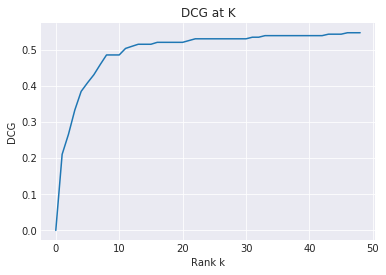

In [17]:
predictions = []
for val in total.values():
    maximum = np.max(val)
    y_pred = np.zeros(shape=(maximum)+1,)
    y_pred[val] = 1
    predictions.append(y_pred)
    
    
ndcgs = []
average_at_k_1 = []

for k in range(1,50):
    ndcgs = [] 
    for pred in predictions:
        ndcgs.append(dcg(pred[0:k], log_base=2))
    ave = np.average(ndcgs)
    average_at_k_1.append(ave)
    
print((average_at_k_1))


plt.plot(average_at_k_1)
plt.xlabel('Rank k')
plt.ylabel('DCG')
plt.title("DCG at K")
plt.show()
    

In [106]:

df_27 = pd.read_hdf(path_or_buf='./data/EventID:27 AND UserID:113223 AND Year:2019.hdf')
df_164 = pd.read_hdf(path_or_buf='./data/EventID:164 AND UserID:113223 AND Year:2019.hdf')

print(list(df_27))
print(list(df_164))

# # Only get the columns
# cols_to_use = df_164.columns.difference(df_27.columns)
# # Wat gebeurd hier precies 
# df = pd.merge(df_27, df_164[cols_to_use],  left_index=True, right_index=True, how='outer')


# df = df.drop(labels=['SiteID', 'Publisher', '_version_', 'AppID', 'DocumentSource', 'Month', 'Publisher', 'ID', 'Week', 'Year', 'FilterPath', 'Quarter'], axis=1)
# df = df.dropna()

# df

# # edge_case = df[df['DocumentPosition'] > df['TotalResult']]


# that_data_frame = df.groupby(['SearchText'])
# that_data_frame.head()

# dat_list = df.values.tolist()
# queries = list(set([element[9] for element in dat_list]))

# total =  {}
# for query in queries:
#     total.update({query : []})
#     for element in dat_list:
#         if query == element[9]:
#             total[query].append(int(element[2]))
            

# predictions = []
# for val in total.values():
#     maximum = np.max(val)
#     y_pred = np.zeros(shape=(maximum)+1,)
#     y_pred[val] = 1
#     predictions.append(y_pred)
    
    
# ndcgs = []
# average_at_k_2 = []

# for k in range(1,50):
#     ndcgs = []  
#     for pred in predictions:
#         ndcgs.append(dcg(pred[0:k], log_base=2))
#     ave = np.average(ndcgs)
#     average_at_k_2.append(ave)
    
# plt.plot(average_at_k_2, label='User 113223')
# plt.plot(average_at_k_1, label='User 155729')

# plt.xlabel('Rank k')
# plt.ylabel('$DCG_{2}$')
# plt.title("$DCG_{2}$ at K")
# plt.legend(loc='lower right')
# plt.show()
    

['AppID', 'CompID', 'DocumentID', 'DocumentPosition', 'DocumentSource', 'DocumentURL', 'EventID', 'ID', 'Month', 'Publisher', 'Quarter', 'SearchTypeID', 'ShortTimeStamp', 'SiteID', 'TimeStamp', 'UserID', 'Week', 'Year', '_version_']
['AppID', 'CompID', 'EventID', 'FilterPath', 'ID', 'Month', 'Quarter', 'SearchText', 'SearchTypeID', 'ShortTimeStamp', 'SiteID', 'TimeStamp', 'TotalResult', 'UserID', 'Week', 'Year', '_version_']


## Dynamic ranking



In [10]:
def request_into_dataframe(rows= 100, query= '*:*', sort=''):
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
    '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    response = requests.get(url)

    # Transform the request into a json
    response = response.json()

    response = response['response']['docs'][1:]

    df =  pd.DataFrame(response)
    
    return df
    

In [11]:
df_27  = request_into_dataframe(rows=100, query='EventID:27 AND UserID:* AND Year:2019', sort='ShortTimeStamp desc')
df_164 = request_into_dataframe(rows=100, query='EventID:164 AND UserID:* AND Year:2019', sort='ShortTimeStamp desc')

cols_to_use = df_27.columns.difference(df_164.columns)

df = pd.merge(df_27, df_164[cols_to_use],  left_index=True, right_index=True, how='outer')


print(list(df_164))
print(list(df_27))

print(cols_to_use)

KeyboardInterrupt: 

In [92]:
from time import strftime, gmtime

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
# df_full_164  = request_into_dataframe(rows=3130500, query='EventID:164 AND UserID:* AND Year:2019', sort='ShortTimeStamp desc')
df_full_164  = request_into_dataframe(rows=930500, query='EventID:164 AND UserID:* AND Year:2019', sort='ShortTimeStamp desc')
print(len(df_164))
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

2019-04-10 11:13:32
99
2019-04-10 11:15:39


In [94]:
print(df_full_164.shape)
print(df_full_164)

(370905, 19)
        AppID  CompID Department  EventID  \
0           1     349        NaN      164   
1           1     444        NaN      164   
2           1     349        NaN      164   
3           1     349        NaN      164   
4           1     349        NaN      164   
5           1     349        NaN      164   
6           1     379        NaN      164   
7           1     349        NaN      164   
8           1     349        NaN      164   
9           1     444        NaN      164   
10          1     349        NaN      164   
11          1     349        NaN      164   
12          1     349        NaN      164   
13          1     349        NaN      164   
14          1     349        NaN      164   
15          1     349        NaN      164   
16          1     444        NaN      164   
17          1     444        NaN      164   
18          1     444        NaN      164   
19          1     444        NaN      164   
20          1     341        NaN      164 

In [101]:
from time import strftime, gmtime

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
# df_full_164  = request_into_dataframe(rows=3130500, query='EventID:164 AND UserID:* AND Year:2019', sort='ShortTimeStamp desc')
df_full_164  = request_into_dataframe(rows=1250500, query='EventID:164 AND UserID:* AND Year:2019', sort='ShortTimeStamp desc')
print(len(df_full_164))
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

2019-04-10 11:23:21
99
2019-04-10 11:24:47


In [103]:
print(df_full_164.shape)
print(len(df_full_164))

print(df_full_164[df_full_164['Year'] == 'afb0fb9e-2b16-47e2-b13c-98a0bee51ee8'])

(370905, 19)
370905
Empty DataFrame
Columns: [AppID, CompID, Department, EventID, FilterPath, FunctionArea, ID, Month, Quarter, SearchText, SearchTypeID, ShortTimeStamp, SiteID, TimeStamp, TotalResult, UserID, Week, Year, _version_]
Index: []


/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [113]:
from time import strftime, gmtime

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
df_full_27  = request_into_dataframe(rows=1228798, query='EventID:27 AND SearchTypeID:14 AND Year:2019')
print(len(df_full_27))
print(df_full_27.shape)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
df.to_hdf('./data/EventID:27Full2019.hdf', key='test', mode='w')



2019-04-10 13:33:50
1227797
(1227797, 21)
2019-04-10 13:47:48


In [114]:
df_full_27.to_hdf('./data/EventID:27Full2019.hdf', key='test', mode='w')

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2378: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['Department', 'DocumentID', 'DocumentSource', 'DocumentURL', 'FunctionArea', 'ID', 'Publisher', 'TimeStamp']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [11]:
from time import strftime, gmtime

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
df_full_164  = request_into_dataframe(rows=1744238, query='EventID:164 AND SearchTypeID:1 AND Year:2019')
print(len(df_full_164))
print(df_full_164.shape)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
df_full_164.to_hdf('./data/EventID:164Full2019.hdf', key='test', mode='w')



2019-04-10 14:39:23
1734237
(1734237, 20)
2019-04-10 14:47:45


ValueError: The file './data/EventID:164Full2019.hdf' is already opened.  Please close it before reopening in write mode.

In [3]:
import tables as tb
try:
   handle.__contains__(handle.root.grades)
   print('contains grades')
except tb.NoSuchNodeError:
   print('there is no grades, will create it')
   handle.create_table('/', 'grades', grades)

df_full_164 = pd.read_hdf(path_or_buf='./data/EventID:164Full2019.hdf', key='test')
# df_full_164 = df_full_164.drop(labels=['AppID','CompID', 'Department', 'FilterPath',
#                          'FunctionArea', 'Month','Quarter','SiteID',
#                           'Week', '_version_','Year'], axis=1)
# df_full_164 = df_full_164.drop(labels=['Year'], axis=1)
# df_full_164.to_hdf('./data/EventID:164Full2019.hdf', key='test', mode='w')


df_full_164

NameError: name 'handle' is not defined

In [9]:
df_full_27 = pd.read_hdf(path_or_buf='./data/EventID:27Full2019.hdf')

# df_full_27 = df_full_27.drop(labels=['AppID', 'CompID', 'Department','DocumentSource','FunctionArea','Month','Publisher','Quarter','SiteID','Week','Year','_version_'], axis=1)
# df_full_27.to_hdf('./data/EventID:27Full2019.hdf', key='test', mode='w')

df_full_27


DocumentID  DocumentPosition  \
0         31084152              15.0   
1         27772772               3.0   
2         26937776               9.0   
4         30335773               8.0   
5         30498876               3.0   
...            ...               ...   
1227791   27082691               3.0   
1227792    7336557               6.0   
1227793   25795961              27.0   
1227794   31522102              10.0   
1227796   23056941               1.0   

                                               DocumentURL  EventID  \
0        http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
1        http://www.legalintelligence.com/documents/loc...       27   
2        http://www.legalintelligence.com/documents/loc...       27   
4        http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
5        https://www.navigator.nl/#/document/id6195b8b5...       27   
...                                                    ...      ...   
1227791  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
1227792  https://www.navigator.nl/#/document/id052e7b69...       27   
1227793  https://www.navigator.nl/#/document/id17fcc43f...       27   
1227794  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
1227796  https://www.navigator.nl/#/document/idpassa7bb...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
0        b5656048-cbe6-4589-b360-85a5c8d3cfe3            14        20190129   
1        ddc7e56a-0dc8-40f4-a32d-743b9128e70c            14        20190129   
2        8619b9d2-8883-4865-a90b-96ad85e99700            14        20190129   
4        cd5e725f-de5a-4b66-bed5-3204acc7a2d3            14        20190129   
5        155203e8-519a-450e-b6ad-5e804bb74c91            14        20190129   
...                                       ...           ...             ...   
1227791  071a6d28-06b9-4233-b1e1-9f0cb5fbf926            14        20190327   
1227792  2a8653c0-144c-4786-adbe-2bd2ff15b61c            14        20190327   
1227793  e21e2dce-96cb-474c-8db9-1eeff0610ff1            14        20190327   
1227794  30436505-a9b9-4037-85bf-da48f1ec18ef            14        20190327   
1227796  158ba076-cf71-4938-b008-3297e6bf8e14            14        20190327   

                        TimeStamp  UserID      SearchText  
0        2019-01-29T14:22:17.419Z  208786             Why  
1        2019-01-29T14:21:19.535Z  216951         Is that  
2        2019-01-29T14:21:21.248Z  152926             How  
4        2019-01-29T14:21:27.293Z   70264             How  
5        2019-01-29T14:21:27.314Z    1055  Example queeer  
...                           ...     ...             ...  
1227791  2019-03-27T14:49:58.117Z  224930         Is that  
1227792  2019-03-27T14:50:02.163Z  123269             Why  
1227793  2019-03-27T14:50:07.548Z  144828             Why  
1227794  2019-03-27T14:50:11.825Z  226535         Is that  
1227796  2019-03-27T14:50:15.044Z  125795  Example queeer  

[903392 rows x 10 columns]

In [93]:
# DO find # unique search text
np.random.randint(low=1, high=150, size=1, dtype='l')

# Insert a random integer to represent searchtext 
# df_full_27['SearchText'] = df_full_27.progress_apply(lambda x: int(np.random.randint(low=1, high=3, size=1, dtype='l')), axis=1)
df_full_27['SearchText'] = df_full_27.progress_apply(lambda x: np.random.choice(["What","Why","How","Is that", "Example queeer"]), axis=1)


df_full_27.to_hdf('./data/EventID:27Full2019.hdf', key='test', mode='w')


HBox(children=(IntProgress(value=0, max=903392), HTML(value='')))

In [12]:
df_full_27 = pd.read_hdf(path_or_buf='./data/EventID:27Full2019.hdf')

df_full_27

first_ten = df_full_27[:10]

DocumentID  DocumentPosition  \
0         31084152              15.0   
1         27772772               3.0   
2         26937776               9.0   
4         30335773               8.0   
5         30498876               3.0   
...            ...               ...   
1227791   27082691               3.0   
1227792    7336557               6.0   
1227793   25795961              27.0   
1227794   31522102              10.0   
1227796   23056941               1.0   

                                               DocumentURL  EventID  \
0        http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
1        http://www.legalintelligence.com/documents/loc...       27   
2        http://www.legalintelligence.com/documents/loc...       27   
4        http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
5        https://www.navigator.nl/#/document/id6195b8b5...       27   
...                                                    ...      ...   
1227791  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
1227792  https://www.navigator.nl/#/document/id052e7b69...       27   
1227793  https://www.navigator.nl/#/document/id17fcc43f...       27   
1227794  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
1227796  https://www.navigator.nl/#/document/idpassa7bb...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
0        b5656048-cbe6-4589-b360-85a5c8d3cfe3            14        20190129   
1        ddc7e56a-0dc8-40f4-a32d-743b9128e70c            14        20190129   
2        8619b9d2-8883-4865-a90b-96ad85e99700            14        20190129   
4        cd5e725f-de5a-4b66-bed5-3204acc7a2d3            14        20190129   
5        155203e8-519a-450e-b6ad-5e804bb74c91            14        20190129   
...                                       ...           ...             ...   
1227791  071a6d28-06b9-4233-b1e1-9f0cb5fbf926            14        20190327   
1227792  2a8653c0-144c-4786-adbe-2bd2ff15b61c            14        20190327   
1227793  e21e2dce-96cb-474c-8db9-1eeff0610ff1            14        20190327   
1227794  30436505-a9b9-4037-85bf-da48f1ec18ef            14        20190327   
1227796  158ba076-cf71-4938-b008-3297e6bf8e14            14        20190327   

                        TimeStamp  UserID      SearchText  
0        2019-01-29T14:22:17.419Z  208786             Why  
1        2019-01-29T14:21:19.535Z  216951         Is that  
2        2019-01-29T14:21:21.248Z  152926             How  
4        2019-01-29T14:21:27.293Z   70264             How  
5        2019-01-29T14:21:27.314Z    1055  Example queeer  
...                           ...     ...             ...  
1227791  2019-03-27T14:49:58.117Z  224930         Is that  
1227792  2019-03-27T14:50:02.163Z  123269             Why  
1227793  2019-03-27T14:50:07.548Z  144828             Why  
1227794  2019-03-27T14:50:11.825Z  226535         Is that  
1227796  2019-03-27T14:50:15.044Z  125795  Example queeer  

[903392 rows x 10 columns]

In [12]:
df_full_27 = df_full_27.dropna(inplace=False)


In [26]:

for user in df_full_27.groupby(by=['UserID','ShortTimeStamp', 'SearchText']):
    print(user)
    
#     for day in user.groupby(by=['ShortTimeStamp', 'SearchText'):
#         pass
        
        #         pass
#         for id3, searchterm in day.groupby(by='SearchText'):
#             if (id1, id2, id3 == 1 ):
#                 pass


((447, 20190110, 'What'),        DocumentID  DocumentPosition  \
543934   30773503               3.0   

                                              DocumentURL  EventID  \
543934  https://www.navigator.nl/#/document/idb7ab5687...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
543934  0e9efd34-30e8-4441-b019-9e8aaed9a2ad            14        20190110   

                       TimeStamp  UserID SearchText  
543934  2019-01-10T14:09:10.263Z     447       What  )
((447, 20190214, 'Example queeer'),        DocumentID  DocumentPosition  \
220409    4717484               6.0   
222219   21489615               1.0   
222243   31256195               2.0   
222416   30969504               6.0   
223440   13001010              16.0   

                                              DocumentURL  EventID  \
220409  https://www.navigator.nl/#/document/id24220091...       27   
222219  https://www.navigator.nl/#/document/idc107231f...       27   
222243 

((501, 20190303, 'Why'),        DocumentID  DocumentPosition  \
797702   22139664               1.0   

                                              DocumentURL  EventID  \
797702  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
797702  1ac491c1-7da1-4d3f-92a1-8164398c8456            14        20190303   

                       TimeStamp  UserID SearchText  
797702  2019-03-03T18:02:49.495Z     501        Why  )
((509, 20190126, 'Example queeer'),        DocumentID  DocumentPosition  \
156521   15620520               1.0   
159310   12390151               1.0   
159326   14441021               5.0   

                                              DocumentURL  EventID  \
156521  https://www.navigator.nl/#/document/id93e3072c...       27   
159310  http://www.arbac.nl/tijdschrift/academievoorar...       27   
159326  https://www.navigator.nl/#/document/id01293e81...       27   

               

((546, 20190129, 'What'),      DocumentID  DocumentPosition  \
3529    7135235               2.0   
4491   30944074               4.0   

                                            DocumentURL  EventID  \
3529  https://zoek.officielebekendmakingen.nl/stb-20...       27   
4491  https://www.navigator.nl/#/document/id864a819a...       27   

                                        ID  SearchTypeID  ShortTimeStamp  \
3529  22827983-55a3-4345-b95d-f2711f664766            14        20190129   
4491  b2da9bc4-2b68-4d5e-9bbb-440ded3a6c82            14        20190129   

                     TimeStamp  UserID SearchText  
3529  2019-01-29T15:08:01.758Z     546       What  
4491  2019-01-29T15:52:45.352Z     546       What  )
((546, 20190130, 'Example queeer'),        DocumentID  DocumentPosition  \
128872    3768439               1.0   

                                              DocumentURL  EventID  \
128872  https://www.navigator.nl/#/document/id15761973...       27   

               

((548, 20190321, 'Why'),         DocumentID  DocumentPosition  \
1095543    4239807              22.0   

                                               DocumentURL  EventID  \
1095543  https://www.navigator.nl/#/document/id10521983...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1095543  82722cac-d91e-42d6-87bb-8e876deeeb2d            14        20190321   

                        TimeStamp  UserID SearchText  
1095543  2019-03-21T14:57:10.602Z     548        Why  )
((548, 20190326, 'How'),         DocumentID  DocumentPosition  \
1214231   17691968               7.0   

                                               DocumentURL  EventID  \
1214231  http://www.legalintelligence.com/documents/loc...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1214231  dc46cf5c-8ea3-489d-8c38-86ca656eb76c            14        20190326   

                        TimeStamp  UserID SearchText  
1214231  2019-03-2

((600, 20190322, 'How'),         DocumentID  DocumentPosition  \
1106278   30780469               6.0   
1108836    3804741              11.0   

                                               DocumentURL  EventID  \
1106278  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
1108836  https://www.navigator.nl/#/document/id28920071...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1106278  4949f9c6-5f4e-4505-83cb-8b5ea700ec3d            14        20190322   
1108836  5883a588-f1fd-4a37-a9f8-c9a9d576a8b1            14        20190322   

                        TimeStamp  UserID SearchText  
1106278  2019-03-22T08:06:09.761Z     600        How  
1108836  2019-03-22T08:11:55.981Z     600        How  )
((600, 20190322, 'Is that'),         DocumentID  DocumentPosition  \
1106256   27056257               4.0   
1106262   27739314               5.0   

                                               DocumentURL  EventID  \
1106256  http:/

1183931  2019-03-25T10:34:26.784Z     702  Example queeer  )
((702, 20190325, 'What'),         DocumentID  DocumentPosition  \
1186815   30190600               4.0   

                                               DocumentURL  EventID  \
1186815  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1186815  0ceb0093-d8b7-4d8a-aa3a-209a1e3125a3            14        20190325   

                        TimeStamp  UserID SearchText  
1186815  2019-03-25T12:55:58.966Z     702       What  )
((770, 20190218, 'Example queeer'),        DocumentID  DocumentPosition  \
296585   30711369               1.0   
296605   15584637               3.0   

                                              DocumentURL  EventID  \
296585  http://portal.squareis.com/pages/home?configOb...       27   
296605  http://portal.squareis.com/pages/home?configOb...       27   

                                          ID  SearchTy

((807, 20190204, 'What'),        DocumentID  DocumentPosition  \
357058   26848741               1.0   

                                              DocumentURL  EventID  \
357058  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
357058  bdc06c2c-6c32-4c3c-85dc-491ad1cd03c2            14        20190204   

                       TimeStamp  UserID SearchText  
357058  2019-02-04T16:39:12.266Z     807       What  )
((807, 20190204, 'Why'),        DocumentID  DocumentPosition  \
351635   27590049               1.0   
357041   25141465               1.0   

                                              DocumentURL  EventID  \
351635  https://www.navigator.nl/#/document/ida34ba2fa...       27   
357041  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
351635  afde5aa0-ba08-496a-a04b-5c64b37803cc            

((891, 20190122, 'Is that'),        DocumentID  DocumentPosition  \
396203   12405589               6.0   

                                              DocumentURL  EventID  \
396203  https://www.navigator.nl/#/document/id37b7011e...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
396203  c86c7dfa-f22e-4a7c-b3e6-26e16513ba07            14        20190122   

                       TimeStamp  UserID SearchText  
396203  2019-01-22T08:30:42.203Z     891    Is that  )
((891, 20190128, 'Example queeer'),        DocumentID  DocumentPosition  \
171751   22116956              20.0   
175212   24149302               4.0   

                                              DocumentURL  EventID  \
171751  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
175212  https://www.navigator.nl/#/document/idac026e76...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
171751  da43d428-9c29-487b-9973-adbc720dd3

((920, 20190217, 'How'),        DocumentID  DocumentPosition  \
303957   31408813               1.0   
304932   28435167               1.0   

                                              DocumentURL  EventID  \
303957  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
304932  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
303957  f3f04e53-20bf-4cdd-90ba-385610e514a0            14        20190217   
304932  58eee822-52db-4842-938b-c6124c2b43a5            14        20190217   

                       TimeStamp  UserID SearchText  
303957  2019-02-17T21:03:18.739Z     920        How  
304932  2019-02-17T20:46:34.828Z     920        How  )
((920, 20190217, 'Is that'),        DocumentID  DocumentPosition  \
304954   31484543               1.0   
308699   31484543               2.0   

                                              DocumentURL  EventID  \
304954  http://www.legalintelli

((932, 20190307, 'What'),        DocumentID  DocumentPosition  \
771646   31558830               4.0   

                                              DocumentURL  EventID  \
771646  https://www.navigator.nl/#/document/id748ecb17...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
771646  f406889b-4470-46fc-929a-615ff76e7fe0            14        20190307   

                       TimeStamp  UserID SearchText  
771646  2019-03-07T09:26:09.737Z     932       What  )
((932, 20190314, 'Example queeer'),         DocumentID  DocumentPosition  \
1027272   31624730               4.0   
1027304   31580584               6.0   

                                               DocumentURL  EventID  \
1027272  https://www.navigator.nl/#/document/id5d2b59fb...       27   
1027304  https://www.navigator.nl/#/document/id0b9fdf7a...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1027272  fd163d07-34b2-4a32-8c35-3fb3e

((973, 20190305, 'Is that'),        DocumentID  DocumentPosition  \
832867   27992415              61.0   

                                              DocumentURL  EventID  \
832867  https://www.navigator.nl/#/document/idf49b8b23...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
832867  24d3b82e-563c-4a70-91af-35483abf2f18            14        20190305   

                       TimeStamp  UserID SearchText  
832867  2019-03-05T11:05:06.938Z     973    Is that  )
((983, 20190204, 'Example queeer'),         DocumentID  DocumentPosition  \
1008420   31418162               2.0   
1020259   31172589               1.0   

                                               DocumentURL  EventID  \
1008420  http://www.bjutijdschriften.nl/tijdschrift/ver...       27   
1020259  https://www.navigator.nl/#/document/idc5919c65...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1008420  65d79fa7-548a-40de-b7a6-ff

((1055, 20190121, 'How'),        DocumentID  DocumentPosition  \
111041    3980836              18.0   
114666   24307895              78.0   

                                              DocumentURL  EventID  \
111041  http://www.legalintelligence.com/documents/loc...       27   
114666  https://www.navigator.nl/#/document/id1bee854e...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
111041  676a3d9a-1238-4426-90a9-61b2d17bc12a            14        20190121   
114666  67bba6a8-8367-4a92-9788-cbaf087fe953            14        20190121   

                       TimeStamp  UserID SearchText  
111041  2019-01-21T15:47:44.709Z    1055        How  
114666  2019-01-21T15:56:22.227Z    1055        How  )
((1055, 20190129, 'Example queeer'),   DocumentID  DocumentPosition  \
5   30498876               3.0   

                                         DocumentURL  EventID  \
5  https://www.navigator.nl/#/document/id6195b8b5...       27   

          

((1140, 20190303, 'Why'),        DocumentID  DocumentPosition  \
795282    3831855              26.0   
796156   24127217              46.0   

                                              DocumentURL  EventID  \
795282  https://www.navigator.nl/#/document/id15771995...       27   
796156  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
795282  7c25027a-c8ee-4f94-a105-6f4562af7923            14        20190303   
796156  065151a9-e9ba-4242-9a1b-b877ed35d942            14        20190303   

                       TimeStamp  UserID SearchText  
795282  2019-03-03T16:16:05.994Z    1140        Why  
796156  2019-03-03T16:12:28.049Z    1140        Why  )
((1140, 20190305, 'Example queeer'),        DocumentID  DocumentPosition  \
837401    3833946               3.0   

                                              DocumentURL  EventID  \
837401  https://www.navigator.nl/#/document/id23081999...    

1113832  2019-03-15T13:06:12.293Z    1194    Is that  )
((1194, 20190315, 'What'),         DocumentID  DocumentPosition  \
1132967   30892541               2.0   
1133056   30773505               4.0   
1134060   30477268               2.0   

                                               DocumentURL  EventID  \
1132967  https://www.navigator.nl/#/document/id7b8d9ff8...       27   
1133056  https://www.navigator.nl/#/document/idfe868b9a...       27   
1134060  https://www.navigator.nl/#/document/id53ac884c...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1132967  ed71db9d-2db3-4352-b8ef-c14343dcf056            14        20190315   
1133056  72c5812c-5867-4a64-bebc-47ffe7736a13            14        20190315   
1134060  a09aa20b-5a13-48dc-a535-7610b409ef49            14        20190315   

                        TimeStamp  UserID SearchText  
1132967  2019-03-15T14:15:21.565Z    1194       What  
1133056  2019-03-15T14:23:51.282Z    1194   

((1197, 20190221, 'How'),        DocumentID  DocumentPosition  \
981871   14996286               1.0   

                                              DocumentURL  EventID  \
981871  http://portal.squareis.com/pages/home?configOb...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
981871  e72471a2-95cd-4242-9905-6bd29b0829f4            14        20190221   

                       TimeStamp  UserID SearchText  
981871  2019-02-21T15:53:10.035Z    1197        How  )
((1197, 20190222, 'Is that'),        DocumentID  DocumentPosition  \
727097   31561970              71.0   

                                              DocumentURL  EventID  \
727097  https://eur-lex.europa.eu/legal-content/NL/TXT...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
727097  4f9601fc-2e58-44db-943b-c09b1dbb635e            14        20190222   

                       TimeStamp  UserID SearchText  
727097  2019-02-22T07:37:56

((1264, 20190118, 'What'),        DocumentID  DocumentPosition  \
612688   31021818               3.0   
612693   31425713               1.0   
613996    3772662               1.0   
614467   21878827               4.0   

                                              DocumentURL  EventID  \
612688  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
612693  http://www.legalintelligence.com/documents/loc...       27   
613996  https://www.navigator.nl/#/document/id15761993...       27   
614467  https://www.navigator.nl/#/document/idpass1a83...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
612688  87838673-4af2-4423-a105-be5a3695aa9f            14        20190118   
612693  12afe52a-92f5-4fa6-af66-09364b41f38d            14        20190118   
613996  f202302d-403e-4472-908d-f78c8d5fe2f3            14        20190118   
614467  5586b3b8-e7eb-481a-804b-d58b9d9a8966            14        20190118   

                       TimeStamp  U

((2576, 20190104, 'How'),        DocumentID  DocumentPosition  \
463719    4527290              11.0   

                                              DocumentURL  EventID  \
463719  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
463719  d7fb8989-a3c6-4e17-9a03-98587760c1cd            14        20190104   

                       TimeStamp  UserID SearchText  
463719  2019-01-04T15:53:04.611Z    2576        How  )
((2576, 20190107, 'Example queeer'),        DocumentID  DocumentPosition  \
499603   14490262               5.0   

                                              DocumentURL  EventID  \
499603  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
499603  b39966b9-0cd1-4d7d-971f-f17c3e15d5b0            14        20190107   

                       TimeStamp  UserID      SearchText  
499603  2019-01

((2741, 20190212, 'What'),        DocumentID  DocumentPosition  \
250249   31017128              21.0   
283951   30445852               2.0   

                                              DocumentURL  EventID  \
250249  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
283951   https://portal.vindbestuursrecht.nl/doc/20019704       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
250249  958c30d3-b0e2-4c4e-bf65-fbf29439c344            14        20190212   
283951  f40212d7-5394-4c23-b5c0-1f32641cb507            14        20190212   

                       TimeStamp  UserID SearchText  
250249  2019-02-12T10:57:39.786Z    2741       What  
283951  2019-02-12T17:30:39.389Z    2741       What  )
((2741, 20190212, 'Why'),        DocumentID  DocumentPosition  \
250145    2308533               1.0   
252459    7961074               6.0   
253688    6463461               8.0   
257029   24400240               5.0   

                        

((2766, 20190312, 'Why'),        DocumentID  DocumentPosition  \
934015   22531239               1.0   
936904    8621035               8.0   

                                              DocumentURL  EventID  \
934015  https://www.navigator.nl/#/document/idpass30e5...       27   
936904  https://www.navigator.nl/#/document/id38c9b422...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
934015  efd70a9e-f8d9-4a9c-b4b5-9b6f26326c70            14        20190312   
936904  7e3c2924-ad45-4d4e-a0f2-29670c1e8905            14        20190312   

                       TimeStamp  UserID SearchText  
934015  2019-03-12T10:56:59.100Z    2766        Why  
936904  2019-03-12T15:09:56.874Z    2766        Why  )
((2766, 20190314, 'Is that'),        DocumentID  DocumentPosition  \
969682   31604622               2.0   
972015   24892557               2.0   

                                              DocumentURL  EventID  \
969682            https://den

((2910, 20190102, 'Example queeer'),        DocumentID  DocumentPosition  \
486567   28505977               2.0   

                                              DocumentURL  EventID  \
486567  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
486567  fde1739c-4383-4e63-b912-c1a7f71216b9            14        20190102   

                       TimeStamp  UserID      SearchText  
486567  2019-01-02T15:25:53.162Z    2910  Example queeer  )
((2910, 20190102, 'Is that'),        DocumentID  DocumentPosition  \
484229   15622674               1.0   

                                              DocumentURL  EventID  \
484229  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
484229  f1529f15-6957-4bdf-8dfe-b5c0f6d0209b            14        20190102   

                       TimeStamp  UserID SearchText  
484229

((2990, 20190125, 'What'),        DocumentID  DocumentPosition  \
143971    4419522               3.0   

                                              DocumentURL  EventID  \
143971  https://www.navigator.nl/#/document/inod11707b...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
143971  3872d492-55a4-420c-8433-bf9024e77d62            14        20190125   

                       TimeStamp  UserID SearchText  
143971  2019-01-25T15:40:46.255Z    2990       What  )
((2990, 20190213, 'Example queeer'),        DocumentID  DocumentPosition  \
285531   31464683               1.0   

                                              DocumentURL  EventID  \
285531  http://tuchtrecht.overheid.nl/zoeken/resultaat...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
285531  50a946de-f461-41ff-b419-a9330b7a4030            14        20190213   

                       TimeStamp  UserID      SearchText  
285531  2019-0

((3045, 20190125, 'What'),        DocumentID  DocumentPosition  \
139795   31070777               2.0   

                                              DocumentURL  EventID  \
139795  https://www.navigator.nl/#/document/idae0c4afb...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
139795  11b69e2f-d4cf-40fe-88ca-2bedf465e7b8            14        20190125   

                       TimeStamp  UserID SearchText  
139795  2019-01-25T10:10:01.502Z    3045       What  )
((3046, 20190102, 'Example queeer'),        DocumentID  DocumentPosition  \
470517   25969944              23.0   
471602   16243450               4.0   
474575    6179759               6.0   
481810   30575363               2.0   
482061    3769974               1.0   
482116   20679207               1.0   
483327   15753831               7.0   

                                              DocumentURL  EventID  \
470517  https://www.navigator.nl/#/document/iddcb75b40...       27 

((3076, 20190204, 'Is that'),        DocumentID  DocumentPosition  \
350902    3959469              80.0   
350927   25164966              82.0   
352962    3823475             106.0   
354995   25795391               5.0   

                                              DocumentURL  EventID  \
350902  http://www.legalintelligence.com/documents/loc...       27   
350927  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
352962  https://www.navigator.nl/#/document/id15761996...       27   
354995  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
350902  80e8bf35-85fc-45a4-b505-76e0e3986de3            14        20190204   
350927  91b6ba53-b36e-44a8-9a75-b39a4ec89417            14        20190204   
352962  e536f76c-f98b-4f82-9ddd-6345e827524e            14        20190204   
354995  05adb139-cbc1-419d-ab73-a13333c41753            14        20190204   

                       TimeStamp

((3519, 20190313, 'Why'),        DocumentID  DocumentPosition  \
960984    4537790              10.0   

                                              DocumentURL  EventID  \
960984  https://www.navigator.nl/#/document/id20492008...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
960984  aea01ad7-4fae-4206-aee2-bf779c41f913            14        20190313   

                       TimeStamp  UserID SearchText  
960984  2019-03-13T12:54:27.948Z    3519        Why  )
((3530, 20190205, 'Example queeer'),        DocumentID  DocumentPosition  \
382536    3730585               7.0   

                                              DocumentURL  EventID  \
382536  https://www.navigator.nl/#/document/id16702000...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
382536  98afa590-1415-48dc-babd-7b2e9d2d62ea            14        20190205   

                       TimeStamp  UserID      SearchText  
382536  2019-02

((3542, 20190219, 'What'),        DocumentID  DocumentPosition  \
322870   31560225               2.0   

                                              DocumentURL  EventID  \
322870  https://zoek.officielebekendmakingen.nl/stb-20...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
322870  5ff8a728-9c3d-4feb-9319-2664824c6acd            14        20190219   

                       TimeStamp  UserID SearchText  
322870  2019-02-19T10:02:04.394Z    3542       What  )
((3542, 20190226, 'How'),        DocumentID  DocumentPosition  \
740932    4402977               5.0   

                                              DocumentURL  EventID  \
740932  https://www.navigator.nl/#/document/inod1eb39d...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
740932  09d636dc-f634-4780-b6fa-87b11788c472            14        20190226   

                       TimeStamp  UserID SearchText  
740932  2019-02-26T10:20:35.58

((3612, 20190207, 'Example queeer'),       DocumentID  DocumentPosition  \
51396    3775722               1.0   

                                             DocumentURL  EventID  \
51396  https://www.navigator.nl/#/document/id15762004...       27   

                                         ID  SearchTypeID  ShortTimeStamp  \
51396  42e5a2a1-b46e-41ac-ac16-c39bbacc4720            14        20190207   

                      TimeStamp  UserID      SearchText  
51396  2019-02-07T10:25:33.389Z    3612  Example queeer  )
((3612, 20190207, 'How'),       DocumentID  DocumentPosition  \
41668    3784896               1.0   
42473    3784849               1.0   
49426    3775805               1.0   

                                             DocumentURL  EventID  \
41668  https://www.navigator.nl/#/document/id24220070...       27   
42473  https://www.navigator.nl/#/document/id24220070...       27   
49426  https://www.navigator.nl/#/document/id15762004...       27   

                   

((3614, 20190306, 'Example queeer'),        DocumentID  DocumentPosition  \
756132   31060575               6.0   

                                              DocumentURL  EventID  \
756132  https://www.navigator.nl/#/document/id08bf41a0...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
756132  6f81e885-a6e7-4b2f-8bb9-2c6489becfab            14        20190306   

                       TimeStamp  UserID      SearchText  
756132  2019-03-06T14:45:24.427Z    3614  Example queeer  )
((3614, 20190306, 'What'),        DocumentID  DocumentPosition  \
752672    7185616               5.0   

                                       DocumentURL  EventID  \
752672  http://hudoc.echr.coe.int/eng?i=001-104951       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
752672  50533f71-e909-4fa5-a145-edc7c2d2ce8d            14        20190306   

                       TimeStamp  UserID SearchText  
752672  2019-03-06T14:1

((3671, 20190202, 'Example queeer'),       DocumentID  DocumentPosition  \
45924   15421859               1.0   
45939    3773958               1.0   

                                             DocumentURL  EventID  \
45924  https://www.navigator.nl/#/document/id896f13ba...       27   
45939  https://www.navigator.nl/#/document/id15761997...       27   

                                         ID  SearchTypeID  ShortTimeStamp  \
45924  7bd7be48-1ed5-4b43-beff-a012b2a80d5f            14        20190202   
45939  4b9f0d2e-0734-4ca4-b7f2-48f925e0cbf8            14        20190202   

                      TimeStamp  UserID      SearchText  
45924  2019-02-02T12:07:02.452Z    3671  Example queeer  
45939  2019-02-02T12:09:36.406Z    3671  Example queeer  )
((3671, 20190204, 'Is that'),        DocumentID  DocumentPosition  \
357071   17739740               7.0   

                                              DocumentURL  EventID  \
357071  http://www.legalintelligence.com/documents/loc

((3800, 20190121, 'Is that'),        DocumentID  DocumentPosition  \
120979   27477831               4.0   
121089   30462563              96.0   
121177   27319891             145.0   
121185   22116636             143.0   
122180   14155741              66.0   
...           ...               ...   
124514   31010161              23.0   
124549   12764259              24.0   
124576    7328238              99.0   
124785   30885127              13.0   
125662   24978382               8.0   

                                              DocumentURL  EventID  \
120979  http://www.legalintelligence.com/documents/loc...       27   
121089  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
121177  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
121185  https://www.ibrtracker.nl/docs/articles/2016/o...       27   
122180  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
...                                                   ...      ...   
124514  htt

((4038, 20190118, 'Is that'),       DocumentID  DocumentPosition  \
59098   30899792               1.0   
60908   31425730              15.0   
61676   14337959              16.0   

                                             DocumentURL  EventID  \
59098  http://www.legalintelligence.com/ProtectedCont...       27   
60908  https://eur-lex.europa.eu/legal-content/NL/TXT...       27   
61676  https://www.navigator.nl/#/document/ida1783baf...       27   

                                         ID  SearchTypeID  ShortTimeStamp  \
59098  2704b90a-64ce-45b8-852f-59da0b244743            14        20190118   
60908  7d9d9830-1c65-40a6-8706-f4b4b96fad98            14        20190118   
61676  bf397eba-fab0-49fe-8b87-6dc4ef16871a            14        20190118   

                      TimeStamp  UserID SearchText  
59098  2019-01-18T13:06:14.047Z    4038    Is that  
60908  2019-01-18T13:44:21.810Z    4038    Is that  
61676  2019-01-18T13:50:10.666Z    4038    Is that  )
((4038, 20190118, 

((4144, 20190307, 'Is that'),        DocumentID  DocumentPosition  \
775799    8251063              17.0   

                                              DocumentURL  EventID  \
775799  http://www.bjutijdschriften.nl/tijdschrift/ven...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
775799  7a3709e4-a14d-4b57-9a32-e0ab9e258e7e            14        20190307   

                       TimeStamp  UserID SearchText  
775799  2019-03-07T17:11:57.450Z    4144    Is that  )
((4222, 20190315, 'What'),         DocumentID  DocumentPosition  \
1040505   16175994               2.0   

                                               DocumentURL  EventID  \
1040505  https://www.navigator.nl/#/document/id55ca8fff...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1040505  045be884-769d-4964-bd25-d9f3ac60a84d            14        20190315   

                        TimeStamp  UserID SearchText  
1040505  2019-03-15

((4466, 20190318, 'Example queeer'),         DocumentID  DocumentPosition  \
1054961   27811004               2.0   

                                               DocumentURL  EventID  \
1054961  http://portal.squareis.com/pages/home?configOb...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1054961  bffe86ac-6858-448f-85a2-2376544340fb            14        20190318   

                        TimeStamp  UserID      SearchText  
1054961  2019-03-18T09:54:43.379Z    4466  Example queeer  )
((4466, 20190319, 'Example queeer'),         DocumentID  DocumentPosition  \
1078202   27807474               3.0   

                                               DocumentURL  EventID  \
1078202  http://portal.squareis.com/pages/home?configOb...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1078202  99ff24d2-56f6-46a7-89cb-7f84514586d6            14        20190319   

                        TimeStamp  User

((4485, 20190129, 'What'),      DocumentID  DocumentPosition  \
5326   27813821               1.0   

                                            DocumentURL  EventID  \
5326  http://portal.squareis.com/pages/home?configOb...       27   

                                        ID  SearchTypeID  ShortTimeStamp  \
5326  45c1584b-08ea-496a-8aec-c47f7130548e            14        20190129   

                     TimeStamp  UserID SearchText  
5326  2019-01-29T15:59:23.872Z    4485       What  )
((4485, 20190129, 'Why'),        DocumentID  DocumentPosition  \
191224   27803257               1.0   

                                              DocumentURL  EventID  \
191224  http://portal.squareis.com/pages/home?configOb...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
191224  82bee183-0f52-4b2c-9fd7-4c59cc6e864f            14        20190129   

                       TimeStamp  UserID SearchText  
191224  2019-01-29T10:45:42.458Z    4485      

((4504, 20190303, 'What'),        DocumentID  DocumentPosition  \
795048   31539997              22.0   

                                              DocumentURL  EventID  \
795048  https://www.navigator.nl/#/document/idpass4e60...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
795048  457804b1-b0bd-48f5-bda8-ad519b929816            14        20190303   

                       TimeStamp  UserID SearchText  
795048  2019-03-03T12:04:26.174Z    4504       What  )
((4567, 20190111, 'Example queeer'),        DocumentID  DocumentPosition                               DocumentURL  \
559711   12979506              16.0  http://www.ie-forum.nl?showArticle=13764   

        EventID                                    ID  SearchTypeID  \
559711       27  4bfa0430-dd42-4e95-8073-e09cd81b43f2            14   

        ShortTimeStamp                 TimeStamp  UserID      SearchText  
559711        20190111  2019-01-11T15:05:31.082Z    4567  Example que

((4593, 20190130, 'Example queeer'),        DocumentID  DocumentPosition  \
128337   30271398               5.0   

                                              DocumentURL  EventID  \
128337  https://zoek.officielebekendmakingen.nl/kst-34...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
128337  99f425d2-aadd-4546-b956-ac523175fe5d            14        20190130   

                       TimeStamp  UserID      SearchText  
128337  2019-01-30T11:36:04.891Z    4593  Example queeer  )
((4593, 20190130, 'How'),        DocumentID  DocumentPosition  \
155771    3774916               4.0   

                                              DocumentURL  EventID  \
155771  https://www.navigator.nl/#/document/id15762001...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
155771  c96aeecf-bcfe-4b1b-bacc-cfbe50e561a6            14        20190130   

                       TimeStamp  UserID SearchText  
155771  20

((4624, 20190208, 'What'),        DocumentID  DocumentPosition  \
262169   15760857               3.0   

                                              DocumentURL  EventID  \
262169  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
262169  d4f8e8bd-9774-480a-9d47-b1d85adee3db            14        20190208   

                       TimeStamp  UserID SearchText  
262169  2019-02-08T14:19:36.841Z    4624       What  )
((4624, 20190313, 'Example queeer'),        DocumentID  DocumentPosition  \
956984   31046365              17.0   
958413   27729327               4.0   

                                              DocumentURL  EventID  \
956984  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
958413  http://www.uitgeverijparis.nl/reader_viewer_li...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
956984  b348b50b-88ef-4a46-b658-37924da321f

((4625, 20190318, 'Is that'),         DocumentID  DocumentPosition  \
1076427    3784928               1.0   
1079707   25245004              38.0   

                                               DocumentURL  EventID  \
1076427  https://www.navigator.nl/#/document/id24220070...       27   
1079707  https://zoek.officielebekendmakingen.nl/stb-20...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1076427  4badb671-0254-4f8d-af9e-9456992d4db9            14        20190318   
1079707  287903bc-68bd-432b-9897-4e4afd1e98b9            14        20190318   

                        TimeStamp  UserID SearchText  
1076427  2019-03-18T15:47:29.108Z    4625    Is that  
1079707  2019-03-18T15:50:19.263Z    4625    Is that  )
((4625, 20190318, 'What'),         DocumentID  DocumentPosition  \
1072863   23765985              10.0   
1074161   25245004              38.0   
1078513   27279161              28.0   

                                           

((4635, 20190305, 'Is that'),        DocumentID  DocumentPosition  \
820588   16229061               2.0   
832637    3994631               1.0   
832648   12555449               5.0   

                                              DocumentURL  EventID  \
820588  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
832637  http://www.legalintelligence.com/documents/loc...       27   
832648  http://www.bjutijdschriften.nl/tijdschrift/maa...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
820588  2e0ce9f7-3bbe-42d4-b68e-15ccecf9fc3f            14        20190305   
832637  859936a4-7168-46ad-b01b-5c044e922994            14        20190305   
832648  9c7e9923-3a51-4b52-8da6-4dad04d1da88            14        20190305   

                       TimeStamp  UserID SearchText  
820588  2019-03-05T09:36:50.912Z    4635    Is that  
832637  2019-03-05T10:48:55.597Z    4635    Is that  
832648  2019-03-05T10:49:17.576Z    4635    Is that  )
((

((4636, 20190228, 'Is that'),        DocumentID  DocumentPosition  \
974761   31011680               4.0   

                                              DocumentURL  EventID  \
974761  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
974761  df1258b0-ea1d-49c7-ad4a-b786d95fac79            14        20190228   

                       TimeStamp  UserID SearchText  
974761  2019-02-28T10:43:40.466Z    4636    Is that  )
((4636, 20190228, 'What'),        DocumentID  DocumentPosition  \
979213   28540309              11.0   

                                              DocumentURL  EventID  \
979213  https://www.internetconsultatie.nl/wijziging_r...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
979213  325b3261-101c-4971-8fb1-cfdb1fbde22b            14        20190228   

                       TimeStamp  UserID SearchText  
979213  2019-02-28T10:18:5

535706  2019-01-10T23:50:31.269Z    4715        Why  )
((4715, 20190128, 'How'),        DocumentID  DocumentPosition  \
391359   31123411               2.0   

                                              DocumentURL  EventID  \
391359  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
391359  7f84be5e-8a2d-4ed7-a5c6-7e6bb67a4b21            14        20190128   

                       TimeStamp  UserID SearchText  
391359  2019-01-28T15:24:35.842Z    4715        How  )
((4715, 20190128, 'What'),        DocumentID  DocumentPosition  \
389246    6336305               3.0   

                                              DocumentURL  EventID  \
389246  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
389246  13e23775-0f72-4e06-8a17-4f34953e16ab            14        20190128   

                       TimeSt

((4769, 20190220, 'Example queeer'),        DocumentID  DocumentPosition  \
344142   23598457               2.0   

                                              DocumentURL  EventID  \
344142  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
344142  b52db9bc-9823-43c8-ba03-37c2082cd18d            14        20190220   

                       TimeStamp  UserID      SearchText  
344142  2019-02-20T08:30:49.808Z    4769  Example queeer  )
((4769, 20190220, 'How'),        DocumentID  DocumentPosition  \
344714   25397503               1.0   
345129   23338203              28.0   

                                              DocumentURL  EventID  \
344714  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
345129  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
344714  932a07ae-ad4e-4bec-960d-ea

((4770, 20190110, 'Why'),        DocumentID  DocumentPosition  \
441211   30852334              11.0   
460706    4525279               5.0   

                                              DocumentURL  EventID  \
441211  https://www.navigator.nl/#/document/id5755ec15...       27   
460706  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
441211  8e534935-6b69-41fa-94ab-37665067ede7            14        20190110   
460706  bdc1f058-3f88-4d89-9fbe-b4d759bd1f3d            14        20190110   

                       TimeStamp  UserID SearchText  
441211  2019-01-10T08:32:16.569Z    4770        Why  
460706  2019-01-10T12:43:46.761Z    4770        Why  )
((4770, 20190117, 'Example queeer'),        DocumentID  DocumentPosition  \
603649   22796656               7.0   

                                              DocumentURL  EventID  \
603649  http://www.legalintelligence.com/documents/loc...    

830676  2019-03-05T13:26:04.667Z    4770       What  )
((4770, 20190312, 'Example queeer'),        DocumentID  DocumentPosition  \
927485    4441643               1.0   
930706    5537804               2.0   
930709    4441653               1.0   
931478    4527544               8.0   
931563   16386287               7.0   
931952   25969951               1.0   

                                              DocumentURL  EventID  \
927485  https://www.navigator.nl/#/document/inod24df02...       27   
930706  https://www.navigator.nl/#/document/inod086c60...       27   
930709  https://www.navigator.nl/#/document/inodf21770...       27   
931478  http://www.legalintelligence.com/documents/loc...       27   
931563  https://www.navigator.nl/#/document/idpass01b6...       27   
931952  https://www.navigator.nl/#/document/ida8cb924c...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
927485  54e6f156-183d-4a55-8149-e6dbfc65901a            14       

((4772, 20190312, 'What'),        DocumentID  DocumentPosition  \
930357   31471437               6.0   
930705    7160336               1.0   

                                              DocumentURL  EventID  \
930357  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
930705  https://www.navigator.nl/#/document/id4be6f03a...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
930357  ec5a72b6-7bb7-47a0-b2a3-1d020c6ba52b            14        20190312   
930705  7ce858f2-5fc6-4071-a554-99d781f6dadd            14        20190312   

                       TimeStamp  UserID SearchText  
930357  2019-03-12T07:58:44.424Z    4772       What  
930705  2019-03-12T08:39:27.665Z    4772       What  )
((4772, 20190312, 'Why'),        DocumentID  DocumentPosition  \
928778    3327088              29.0   
928905    2358786              61.0   
928909    3900813              56.0   
931612    3795789              16.0   

                        

((5256, 20190111, 'What'),        DocumentID  DocumentPosition  \
652474   26848331               3.0   

                                              DocumentURL  EventID  \
652474  https://www.navigator.nl/#/document/id6fdc0de6...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
652474  ab315c28-7280-40a3-b790-c2ae96598bb5            14        20190111   

                       TimeStamp  UserID SearchText  
652474  2019-01-11T14:18:26.748Z    5256       What  )
((5256, 20190111, 'Why'),        DocumentID  DocumentPosition  \
653753   24814205               1.0   

                                              DocumentURL  EventID  \
653753  https://www.navigator.nl/#/document/idpassc8b1...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
653753  113bbf21-438a-4774-8a5c-e5c329fee899            14        20190111   

                       TimeStamp  UserID SearchText  
653753  2019-01-11T14:14:08.58

686038  2019-02-22T21:11:18.052Z    5417    Is that  )
((5417, 20190222, 'What'),        DocumentID  DocumentPosition  \
671814    7163366               1.0   

                                              DocumentURL  EventID  \
671814  https://www.navigator.nl/#/document/id7e8e643e...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
671814  c8e49a16-3b8f-47b4-a8fd-6f5e66daf97a            14        20190222   

                       TimeStamp  UserID SearchText  
671814  2019-02-22T22:14:07.842Z    5417       What  )
((5417, 20190301, 'Why'),        DocumentID  DocumentPosition  \
876991   26949814               5.0   

                                              DocumentURL  EventID  \
876991  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
876991  c69b9f99-91c7-43cf-99bf-b10d5a4a4a5b            14        20190301   

                       TimeSt

((5634, 20190115, 'How'),        DocumentID  DocumentPosition  \
644933   23235809              14.0   

                                              DocumentURL  EventID  \
644933  http://www.bjutijdschriften.nl/tijdschrift/maa...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
644933  2afeed01-2a5e-4937-a297-ac8111d844ec            14        20190115   

                       TimeStamp  UserID SearchText  
644933  2019-01-15T11:33:10.719Z    5634        How  )
((5634, 20190115, 'Is that'),        DocumentID  DocumentPosition                              DocumentURL  \
644935   30971825               2.0  https://denhollander.info/artikel/15207   

        EventID                                    ID  SearchTypeID  \
644935       27  bcba729c-743f-4ff6-b163-28f1b65ac717            14   

        ShortTimeStamp                 TimeStamp  UserID SearchText  
644935        20190115  2019-01-15T11:33:23.267Z    5634    Is that  )
((5634, 20190

((5705, 20190115, 'What'),        DocumentID  DocumentPosition  \
637083   31410732               1.0   

                                              DocumentURL  EventID  \
637083  https://www.navigator.nl/#/document/id1330a513...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
637083  9cfacf88-ebe6-4931-b30a-e7c92600e44c            14        20190115   

                       TimeStamp  UserID SearchText  
637083  2019-01-15T08:24:38.563Z    5705       What  )
((5705, 20190115, 'Why'),        DocumentID  DocumentPosition  \
640326   30855123               1.0   

                                              DocumentURL  EventID  \
640326  http://portal.squareis.com/pages/home?configOb...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
640326  1677d412-91f5-442e-912c-33f21c82504c            14        20190115   

                       TimeStamp  UserID SearchText  
640326  2019-01-15T08:49:41.20

((5725, 20190316, 'What'),         DocumentID  DocumentPosition  \
1148779    4491439               1.0   

                                               DocumentURL  EventID  \
1148779  https://zoek.officielebekendmakingen.nl/kst-32...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1148779  171a0c1c-df71-4b2c-b3a0-b0a1148b8503            14        20190316   

                        TimeStamp  UserID SearchText  
1148779  2019-03-16T14:04:28.332Z    5725       What  )
((5725, 20190316, 'Why'),         DocumentID  DocumentPosition  \
1147312    3274093               1.0   
1147544   30688989              23.0   
1149093   30145307               1.0   

                                               DocumentURL  EventID  \
1147312  https://zoek.officielebekendmakingen.nl/kst-32...       27   
1147544  https://www.rijksoverheid.nl/documenten/kamers...       27   
1149093  http://www.legalintelligence.com/documents/loc...       27   

       

((5878, 20190119, 'Example queeer'),       DocumentID  DocumentPosition  \
88065   31070863               4.0   

                                             DocumentURL  EventID  \
88065  https://www.navigator.nl/#/document/idb5dee0a3...       27   

                                         ID  SearchTypeID  ShortTimeStamp  \
88065  3aaddeee-4ae4-4fcf-ac48-2a5ddc3098ac            14        20190119   

                      TimeStamp  UserID      SearchText  
88065  2019-01-19T16:14:27.255Z    5878  Example queeer  )
((5878, 20190119, 'What'),       DocumentID  DocumentPosition  \
83353   31255892               2.0   

                                             DocumentURL  EventID  \
83353  https://www.navigator.nl/#/document/id7bed8e0a...       27   

                                         ID  SearchTypeID  ShortTimeStamp  \
83353  a086bbbe-8514-4652-9f50-d08f48fe0c29            14        20190119   

                      TimeStamp  UserID SearchText  
83353  2019-01-19T16:31:

((5878, 20190303, 'What'),        DocumentID  DocumentPosition  \
793898   31431106               6.0   

                                              DocumentURL  EventID  \
793898  https://www.navigator.nl/#/document/ide7d5d298...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
793898  f3a098bd-db3f-4dff-b3e0-b50a554c3c9a            14        20190303   

                       TimeStamp  UserID SearchText  
793898  2019-03-03T21:06:58.094Z    5878       What  )
((5878, 20190303, 'Why'),        DocumentID  DocumentPosition  \
793905   31581631              34.0   

                                              DocumentURL  EventID  \
793905  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
793905  23b56398-20f7-4b13-a8f3-0d916e323a8b            14        20190303   

                       TimeStamp  UserID SearchText  
793905  2019-03-03T21:08:02.64

((5913, 20190208, 'How'),        DocumentID  DocumentPosition  \
196086   31057516               1.0   
197269   27816298               1.0   
198236   28282395               1.0   
198331   30712316               1.0   

                                              DocumentURL  EventID  \
196086  http://www.ar-updates.nl/samenvatting/AR_2018_...       27   
197269  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
198236  http://www.legalintelligence.com/documents/loc...       27   
198331  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
196086  7873f0e5-0e72-45fc-901f-28b17955dfbe            14        20190208   
197269  1fef7deb-96fd-4ac6-9742-53340420fd38            14        20190208   
198236  8f4b1fc0-7321-452e-8bd1-86b487b024e3            14        20190208   
198331  78581f20-0a2f-4578-93bb-28fccf592018            14        20190208   

                       TimeStamp  Us

20855  2019-02-01T10:27:36.336Z    6188        Why  )
((6188, 20190204, 'How'),        DocumentID  DocumentPosition  \
353810    4395563               1.0   

                                              DocumentURL  EventID  \
353810  https://www.navigator.nl/#/document/inodb9971e...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
353810  4ab93db2-533c-4a6b-af7b-150f4c100867            14        20190204   

                       TimeStamp  UserID SearchText  
353810  2019-02-04T09:40:59.345Z    6188        How  )
((6188, 20190204, 'Why'),        DocumentID  DocumentPosition  \
353695    3823667               2.0   

                                              DocumentURL  EventID  \
353695  https://www.navigator.nl/#/document/id15761997...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
353695  2f98b97b-4474-4479-bb83-194dc0630e8d            14        20190204   

                       TimeStam

((6230, 20190116, 'How'),        DocumentID  DocumentPosition  \
577518   31402933               4.0   
577526   30520921               5.0   
578688   30684289               1.0   

                                              DocumentURL  EventID  \
577518  https://www.navigator.nl/#/document/iddc8a5daf...       27   
577526               http://www.ndfr.nl/link/NTFRB2018-29       27   
578688  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
577518  ffd18bfd-02cc-4802-be0a-26265f64aa35            14        20190116   
577526  793211c3-64e0-4d10-badb-fc6de431d69f            14        20190116   
578688  15fd766a-d9d1-4339-b0bf-fc5963f6421d            14        20190116   

                       TimeStamp  UserID SearchText  
577518  2019-01-16T11:16:56.842Z    6230        How  
577526  2019-01-16T11:17:30.684Z    6230        How  
578688  2019-01-16T11:14:39.148Z    6230        How  )
((6230

((6230, 20190312, 'How'),        DocumentID  DocumentPosition  \
926882   30882923             223.0   
929576   31571156              32.0   
932433   31535969              30.0   
936219   31224075               3.0   
936877   31445252               1.0   
942834   14866375               5.0   
943879   14866375               5.0   
945980   31224075               3.0   
946099   11789043               1.0   

                                              DocumentURL  EventID  \
926882  https://www.navigator.nl/#/document/idc98c2a5b...       27   
929576  https://www.navigator.nl/#/document/idac4edc13...       27   
932433  https://www.navigator.nl/#/document/id464ada0e...       27   
936219  https://opendata.rijksoverheid.nl/binaries/rij...       27   
936877  https://www.navigator.nl/#/document/idpass50b9...       27   
942834  https://www.navigator.nl/#/document/id3ab7bedc...       27   
943879  https://www.navigator.nl/#/document/id3ab7bedc...       27   
945980  https://opendat

((6273, 20190131, 'How'),         DocumentID  DocumentPosition  \
1010240   14992236               1.0   
1011541    8280812               1.0   
1011739    3770435               1.0   
1011743    3770435               1.0   

                                               DocumentURL  EventID  \
1010240  https://www.navigator.nl/#/document/id395c6763...       27   
1011541  http://www.legalintelligence.com/documents/loc...       27   
1011739  https://www.navigator.nl/#/document/id15761985...       27   
1011743  https://www.navigator.nl/#/document/id15761985...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1010240  d80dd1b2-25ea-4cf9-a422-32c7d525bd05            14        20190131   
1011541  b7844376-dcbc-40e0-b2d1-abaf81197f0f            14        20190131   
1011739  b92a9711-84e2-44b3-a0ae-d51468e5f781            14        20190131   
1011743  19ebd3a7-5009-46d9-8b82-39a38c1ffd4e            14        20190131   

                     

((6280, 20190107, 'Is that'),        DocumentID  DocumentPosition  \
458236    1304876              23.0   

                                              DocumentURL  EventID  \
458236  https://zoek.officielebekendmakingen.nl/kst-30...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
458236  1ea26e2c-de2a-437d-ab21-16f841298ea7            14        20190107   

                       TimeStamp  UserID SearchText  
458236  2019-01-07T15:27:13.034Z    6280    Is that  )
((6280, 20190107, 'What'),        DocumentID  DocumentPosition  \
458286    4517622              22.0   

                                              DocumentURL  EventID  \
458286  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
458286  9bbb1e77-96c4-4b22-8907-1b7f6eda65de            14        20190107   

                       TimeStamp  UserID SearchText  
458286  2019-01-07T15:31:4

((6280, 20190326, 'Why'),         DocumentID  DocumentPosition  \
1209819   30230827               1.0   
1212127   31725797               1.0   

                                               DocumentURL  EventID  \
1209819  http://www.legalintelligence.com/documents/loc...       27   
1212127  https://zoek.officielebekendmakingen.nl/kst-87...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1209819  3656d5cf-98ac-48bb-80f7-a32d8da53320            14        20190326   
1212127  486984be-2681-4fec-9d83-75beb2028f77            14        20190326   

                        TimeStamp  UserID SearchText  
1209819  2019-03-26T12:30:11.239Z    6280        Why  
1212127  2019-03-26T14:46:23.773Z    6280        Why  )
((6281, 20190101, 'Is that'),        DocumentID  DocumentPosition  \
461085   31160848               1.0   
461425   31160848               1.0   

                                              DocumentURL  EventID  \
461085  http://ww

((6294, 20190113, 'What'),        DocumentID  DocumentPosition  \
614715   30969451               4.0   

                                              DocumentURL  EventID  \
614715  https://www.navigator.nl/#/document/id35f62123...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
614715  d2f34db0-31ac-4469-829e-32474c2745e9            14        20190113   

                       TimeStamp  UserID SearchText  
614715  2019-01-13T18:46:23.499Z    6294       What  )
((6294, 20190113, 'Why'),        DocumentID  DocumentPosition  \
573048    3768962               1.0   

                                              DocumentURL  EventID  \
573048  https://www.navigator.nl/#/document/id15761977...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
573048  1b2abb76-1655-44b0-965c-6d03e22e3640            14        20190113   

                       TimeStamp  UserID SearchText  
573048  2019-01-13T14:10:31.10

((6334, 20190226, 'How'),        DocumentID  DocumentPosition  \
739354   13596423              14.0   
995612   12389201              22.0   

                                              DocumentURL  EventID  \
739354  https://www.navigator.nl/#/document/idpass521c...       27   
995612  https://www.navigator.nl/#/document/iddb5951ab...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
739354  432d27be-ae85-4923-a252-162b2b1f253e            14        20190226   
995612  924332ed-dd9f-4e17-9ae0-2b53bcad9af6            14        20190226   

                       TimeStamp  UserID SearchText  
739354  2019-02-26T10:13:28.962Z    6334        How  
995612  2019-02-26T10:28:11.950Z    6334        How  )
((6334, 20190226, 'Is that'),        DocumentID  DocumentPosition  \
995678    7564537              27.0   

                                              DocumentURL  EventID  \
995678  https://www.navigator.nl/#/document/id78fc67df...       27  

449592  2019-01-09T20:12:37.490Z    6859       What  )
((6859, 20190110, 'How'),        DocumentID  DocumentPosition  \
533619    8270842               4.0   
534375    8253291               1.0   

                                              DocumentURL  EventID  \
533619  https://www.navigator.nl/#/document/id025b9a11...       27   
534375  http://www.bjutijdschriften.nl/tijdschrift/ven...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
533619  3ac0b81c-73be-43a1-9622-5b591dc33018            14        20190110   
534375  0c0017a5-6ff0-47ce-8360-6d7221214b22            14        20190110   

                       TimeStamp  UserID SearchText  
533619  2019-01-10T20:35:46.265Z    6859        How  
534375  2019-01-10T17:44:22.624Z    6859        How  )
((6859, 20190110, 'Is that'),        DocumentID  DocumentPosition  \
456173    5759529              18.0   

                                              DocumentURL  EventID  \
456173  https

((6859, 20190211, 'How'),        DocumentID  DocumentPosition  \
429920    6761246               2.0   

                                              DocumentURL  EventID  \
429920  https://www.navigator.nl/#/document/inoddc99c8...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
429920  5f7d0d0c-b3b5-45f7-8447-d22149588a9e            14        20190211   

                       TimeStamp  UserID SearchText  
429920  2019-02-11T15:27:54.891Z    6859        How  )
((6859, 20190214, 'Example queeer'),        DocumentID  DocumentPosition  \
211241    3996999               1.0   
220100    5776193               2.0   
223275    4419577               4.0   

                                              DocumentURL  EventID  \
211241  http://www.legalintelligence.com/documents/loc...       27   
220100  https://www.navigator.nl/#/document/inod9d0da7...       27   
223275  https://www.navigator.nl/#/document/inod32683b...       27   

             

((6859, 20190319, 'Example queeer'),         DocumentID  DocumentPosition  \
1139424   14289432               4.0   
1139711    8245941              18.0   
1145693   12943867               1.0   

                                               DocumentURL  EventID  \
1139424  http://www.legalintelligence.com/documents/loc...       27   
1139711  http://www.bjutijdschriften.nl/tijdschrift/ond...       27   
1145693  http://www.legalintelligence.com/documents/loc...       27   

                                           ID  SearchTypeID  ShortTimeStamp  \
1139424  f02521c0-383b-4361-a14f-1dc1b1eef8c7            14        20190319   
1139711  d52966e8-83b2-4733-8469-6fca3de6ff40            14        20190319   
1145693  ea6b0d3c-8d6a-4d42-8ba7-63b09ddba27a            14        20190319   

                        TimeStamp  UserID      SearchText  
1139424  2019-03-19T14:35:20.350Z    6859  Example queeer  
1139711  2019-03-19T14:57:40.906Z    6859  Example queeer  
1145693  2019-03-19T

((7004, 20190301, 'How'),        DocumentID  DocumentPosition  \
879693   30329058               4.0   

                                              DocumentURL  EventID  \
879693  http://www.bjutijdschriften.nl/tijdschrift/tij...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
879693  c84fec7f-1d25-43e4-a33e-fcc5d8ab64b7            14        20190301   

                       TimeStamp  UserID SearchText  
879693  2019-03-01T09:44:02.243Z    7004        How  )
((7004, 20190301, 'Is that'),        DocumentID  DocumentPosition                         DocumentURL  \
876984    6537259               7.0  http://www.ndfr.nl/link/HvJC295-97   

        EventID                                    ID  SearchTypeID  \
876984       27  49e478e2-2e38-420a-b7f6-bc180fefa3ff            14   

        ShortTimeStamp                 TimeStamp  UserID SearchText  
876984        20190301  2019-03-01T10:35:44.137Z    7004    Is that  )
((7004, 20190301, 'Why'

((7017, 20190312, 'How'),        DocumentID  DocumentPosition  \
926684    3772954               1.0   
926692    3775295               1.0   
927787    3769676               1.0   
932561    4243680               3.0   
932650    3774355               1.0   
942847    6329057               1.0   
945097    4242522               4.0   

                                              DocumentURL  EventID  \
926684  https://www.navigator.nl/#/document/id15761994...       27   
926692  https://www.navigator.nl/#/document/id15762002...       27   
927787  https://www.navigator.nl/#/document/id15761981...       27   
932561  https://www.navigator.nl/#/document/id17951994...       27   
932650  https://www.navigator.nl/#/document/id15761999...       27   
942847  https://www.navigator.nl/#/document/id49c51c72...       27   
945097  https://www.navigator.nl/#/document/id15762000...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
926684  d3f3c452-ff03-

((7025, 20190213, 'Example queeer'),        DocumentID  DocumentPosition  \
212095   23164553               2.0   

                                              DocumentURL  EventID  \
212095  https://www.navigator.nl/#/document/id80e558cc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
212095  6cb0ca7e-fa08-4b73-bcf4-99a6d56b27fa            14        20190213   

                       TimeStamp  UserID      SearchText  
212095  2019-02-13T15:38:19.140Z    7025  Example queeer  )
((7025, 20190213, 'Is that'),        DocumentID  DocumentPosition  \
217800   30335883               5.0   
217916   15533390               2.0   

                                              DocumentURL  EventID  \
217800  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
217916  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
217800  30485dd4-7195-4c83-a82

((7320, 20190121, 'What'),        DocumentID  DocumentPosition  \
109181   29429418               2.0   

                                              DocumentURL  EventID  \
109181  http://www.legalintelligence.com/documents/loc...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
109181  b2d8b157-d3c7-4470-8898-592e65e02e0c            14        20190121   

                       TimeStamp  UserID SearchText  
109181  2019-01-21T14:40:48.290Z    7320       What  )
((7320, 20190121, 'Why'),        DocumentID  DocumentPosition  \
109165   28173282              14.0   
109182   29824165               1.0   
109189   24158759               4.0   

                                              DocumentURL  EventID  \
109165  http://www.legalintelligence.com/documents/loc...       27   
109182  http://www.legalintelligence.com/documents/loc...       27   
109189  http://www.legalintelligence.com/documents/loc...       27   

                       

((7437, 20190111, 'Example queeer'),        DocumentID  DocumentPosition  \
647217   31226536               5.0   
647274   25860587              13.0   

                                              DocumentURL  EventID  \
647217  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
647274  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
647217  439b3c98-f304-4e6a-a178-7d4703b073b2            14        20190111   
647274  bfea50ff-f0c9-4d6a-8234-c29c18514f91            14        20190111   

                       TimeStamp  UserID      SearchText  
647217  2019-01-11T16:22:21.665Z    7437  Example queeer  
647274  2019-01-11T16:27:36.127Z    7437  Example queeer  )
((7437, 20190111, 'How'),        DocumentID  DocumentPosition  \
647260   31226490               6.0   

                                              DocumentURL  EventID  \
647260  http://deeplink.rechtspraak.nl/uitspra

((7438, 20190205, 'Why'),       DocumentID  DocumentPosition  \
14109    2120566               9.0   
14112    3769794              16.0   
17404    3852658              38.0   
17425    4600394               3.0   

                                             DocumentURL  EventID  \
14109  https://www.ibrtracker.nl/docs/articles/2008/f...       27   
14112  https://www.navigator.nl/#/document/id15761982...       27   
17404  https://www.navigator.nl/#/document/id18401983...       27   
17425  https://www.navigator.nl/#/document/inoddd55f9...       27   

                                         ID  SearchTypeID  ShortTimeStamp  \
14109  43d1967b-c79c-4a75-b999-133d4c3f9d4f            14        20190205   
14112  98b5c51a-f2bf-4186-beda-6bc3fcb9e07c            14        20190205   
17404  b5779dbb-68bd-4635-b161-b477c0b04be1            14        20190205   
17425  79cbcff3-5a3e-4642-aa83-4fecd75ff138            14        20190205   

                      TimeStamp  UserID SearchText 

((7490, 20190206, 'Example queeer'),       DocumentID  DocumentPosition  \
11579   11859258              14.0   

                                             DocumentURL  EventID  \
11579  https://www.navigator.nl/#/document/idebd40ead...       27   

                                         ID  SearchTypeID  ShortTimeStamp  \
11579  cdf3a5e1-4aff-4a35-881a-9124cd74bc85            14        20190206   

                      TimeStamp  UserID      SearchText  
11579  2019-02-06T13:25:19.250Z    7490  Example queeer  )
((7490, 20190206, 'How'),       DocumentID  DocumentPosition  \
8251     4396751              15.0   
13687   11859278              10.0   

                                             DocumentURL  EventID  \
8251   https://www.navigator.nl/#/document/inod3c75c8...       27   
13687  https://www.navigator.nl/#/document/idfd1c98b7...       27   

                                         ID  SearchTypeID  ShortTimeStamp  \
8251   2e1c8fc1-c6cc-4585-9ded-2e28826b1824      

((7609, 20190305, 'Is that'),        DocumentID  DocumentPosition  \
841338   17465337              21.0   

                                              DocumentURL  EventID  \
841338  https://www.navigator.nl/#/document/ided681c30...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
841338  c799cd27-bc91-49ee-abe3-cccf97acc130            14        20190305   

                       TimeStamp  UserID SearchText  
841338  2019-03-05T19:33:34.956Z    7609    Is that  )
((7609, 20190305, 'What'),        DocumentID  DocumentPosition  \
746722   15543833              13.0   

                                              DocumentURL  EventID  \
746722  https://www.navigator.nl/#/document/id2357754d...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
746722  4280643c-11df-4a89-a52c-1e24ff410b58            14        20190305   

                       TimeStamp  UserID SearchText  
746722  2019-03-05T20:47:4

((7672, 20190131, 'How'),        DocumentID  DocumentPosition  \
164436    4506190               1.0   

                                              DocumentURL  EventID  \
164436  https://www.navigator.nl/#/document/id8add35c3...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
164436  885781a8-5c56-46a0-8911-081edf992d33            14        20190131   

                       TimeStamp  UserID SearchText  
164436  2019-01-31T09:10:55.681Z    7672        How  )
((7672, 20190131, 'Is that'),        DocumentID  DocumentPosition  \
161987    4506190               1.0   

                                              DocumentURL  EventID  \
161987  https://www.navigator.nl/#/document/id8add35c3...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
161987  91f60ad4-f17a-4fbe-8d85-654b57c94eaa            14        20190131   

                       TimeStamp  UserID SearchText  
161987  2019-01-31T09:14:07

KeyboardInterrupt: 

In [14]:
check = df_full_27['UserID'].unique().tolist()
check = sorted(check)

check

[447,
 448,
 501,
 509,
 514,
 537,
 546,
 548,
 560,
 577,
 600,
 601,
 616,
 618,
 620,
 624,
 653,
 672,
 690,
 700,
 702,
 770,
 784,
 796,
 807,
 842,
 856,
 860,
 866,
 869,
 875,
 887,
 890,
 891,
 907,
 908,
 909,
 911,
 914,
 920,
 925,
 928,
 932,
 954,
 968,
 970,
 973,
 983,
 999,
 1018,
 1022,
 1032,
 1039,
 1048,
 1051,
 1055,
 1069,
 1073,
 1077,
 1083,
 1091,
 1096,
 1111,
 1125,
 1140,
 1194,
 1197,
 1264,
 1298,
 1302,
 1320,
 1321,
 1327,
 2576,
 2668,
 2741,
 2766,
 2795,
 2840,
 2885,
 2900,
 2910,
 2988,
 2990,
 2997,
 3027,
 3034,
 3035,
 3043,
 3045,
 3046,
 3058,
 3072,
 3076,
 3077,
 3108,
 3148,
 3455,
 3473,
 3474,
 3519,
 3530,
 3536,
 3540,
 3542,
 3546,
 3549,
 3553,
 3558,
 3612,
 3614,
 3615,
 3643,
 3671,
 3727,
 3739,
 3759,
 3777,
 3800,
 3803,
 3829,
 4013,
 4033,
 4038,
 4039,
 4040,
 4118,
 4121,
 4125,
 4132,
 4144,
 4222,
 4227,
 4245,
 4253,
 4447,
 4465,
 4466,
 4470,
 4479,
 4485,
 4503,
 4504,
 4567,
 4571,
 4582,
 4585,
 4587,
 4591,
 4593,

## Check each unique ID for multiple queries




In [27]:
# Alle unieke ID's

we_are_ALL_unqiue = []

for unique_id in tqdm(check):
    
    df = df_full_27[df_full_27['UserID'] == unique_id]
    stamps = df['ShortTimeStamp'].sort_values().unique().tolist()
    
    
    unique_dicto = {}
    
    # per time stamp
    for time_id in stamps:
        
        df_ti = df[df['ShortTimeStamp'] == time_id]
        
        duplicates = df_ti[df_ti['SearchText'].duplicated(keep=False)].index.tolist()
    
        for idx, row in enumerate(df_ti.values):
            if idx in duplicates:
                if df_ti['SearchText'][idx] in unique_dicto.keys():
                    print("key aanwezig" ,df_ti['DocumentPosition'][idx])
                    unique_dicto[df_ti['SearchText'][idx]].append(df_ti['DocumentPosition'][idx])
                else:
                    print("key niet aanwezig" ,df_ti['DocumentPosition'][idx])

                    unique_dicto.update({df_ti['SearchText'][idx] : [df_ti['DocumentPosition'][idx]]})
        we_are_ALL_unqiue.append(unique_dicto)

we_are_ALL_unqiue
        
                                  

HBox(children=(IntProgress(value=0, max=26381), HTML(value='')))

KeyboardInterrupt: 

In [98]:
duplicates



DocumentID  DocumentPosition  \
219522   31504094               3.0   
219525   31504094               3.0   
220409    4717484               6.0   
220426    4189599              14.0   
221258   31096629              12.0   
...           ...               ...   
223440   13001010              16.0   
223444    3851359              18.0   
224429   23372435              12.0   
224471    5783327              13.0   
225382   12683065               8.0   

                                              DocumentURL  EventID  \
219522  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
219525  http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
220409  https://www.navigator.nl/#/document/id24220091...       27   
220426  https://www.navigator.nl/#/document/ida29c4ee3...       27   
221258  https://www.navigator.nl/#/document/lex9573c9e...       27   
...                                                   ...      ...   
223440  https://www.navigator.nl/#/document/idf174c256...       27   
223444  https://www.navigator.nl/#/document/idb546dc89...       27   
224429  https://www.navigator.nl/#/document/idf132263a...       27   
224471  https://www.navigator.nl/#/document/id15762009...       27   
225382  https://www.navigator.nl/#/document/id80e63fa0...       27   

                                          ID  SearchTypeID  ShortTimeStamp  \
219522  1a783798-87db-40d9-8d5c-8a8e3bd93564            14        20190214   
219525  9ec65dee-6852-4033-a899-b078c44927e2            14        20190214   
220409  1939cbff-81bf-480f-b96e-dbecd334c2e0            14        20190214   
220426  6f8de9e1-a514-451f-b86f-6640b22e1f30            14        20190214   
221258  542d5fac-7391-4c44-8905-ff633b649062            14        20190214   
...                                      ...           ...             ...   
223440  86dd5f71-bbcd-4050-a6c5-6ac82c27b3b2            14        20190214   
223444  f08eecfa-16dd-484b-80b7-fa10e71a1b7f            14        20190214   
224429  a8b8fa8e-ab5e-4489-91b8-0a88330ae0fd            14        20190214   
224471  3da6a354-95e8-4645-96fd-b94e405c9fb2            14        20190214   
225382  8d7330ff-5945-4171-ba05-2dba76c402c3            14        20190214   

                       TimeStamp  UserID      SearchText  
219522  2019-02-14T16:29:28.199Z     447             How  
219525  2019-02-14T16:29:39.876Z     447             Why  
220409  2019-02-14T15:50:41.233Z     447  Example queeer  
220426  2019-02-14T16:08:23.613Z     447             Why  
221258  2019-02-14T15:36:50.625Z     447             How  
...                          ...     ...             ...  
223440  2019-02-14T16:14:36.005Z     447  Example queeer  
223444  2019-02-14T16:14:25.084Z     447            What  
224429  2019-02-14T16:04:46.067Z     447             How  
224471  2019-02-14T16:06:47.753Z     447            What  
225382  2019-02-14T16:03:08.918Z     447             Why  

[15 rows x 10 columns]

In [27]:
dates = pd.date_range('20190101',periods=6)


df = pd.DataFrame({"DocumentID"      : [419,384,452,938],
                  "DocumentPosition" : [2,2,5,8],
                  "ShortTimeStamp"   : [20190214,20190214,20190214,20190214],
                  "SearchText"       : ['How', "Why","How","Test Query"]})

df

duplicates = df[df['SearchText'].duplicated(keep=False)].index.tolist()

dicto = {}
for idx, row in enumerate(df.values):
    if idx in duplicates:
        if df['SearchText'][idx] in dicto.keys():
            dicto[df['SearchText'][idx]].append(df['DocumentPosition'][idx])
        else:
            dicto.update({df['SearchText'][idx] : [df['DocumentPosition'][idx]]})
        
        
dicto

DocumentID  DocumentPosition  ShortTimeStamp  SearchText
0         419                 2        20190214         How
1         384                 2        20190214         Why
2         452                 5        20190214         How
3         938                 8        20190214  Test Query

{'How': [2, 5]}

In [15]:

df_full_27 = pd.read_hdf(path_or_buf='./data/EventID:27Full2019.hdf')


first_ten = df_full_27[:10]
columns = ['20190101','20190101','20190101','20190101','20190103','20190103','20190103','20190103', '20190104', '20190104']
userid_cols = ['208786','208786','208786','208786','208786', '1055','1055','1055','1055','1055']
first_ten['ShortTimeStamp'] = columns
first_ten['UserID'] = userid_cols
first_ten


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


DocumentID  DocumentPosition  \
0    31084152              15.0   
1    27772772               3.0   
2    26937776               9.0   
4    30335773               8.0   
5    30498876               3.0   
6     4685978               1.0   
7     6833986               9.0   
8    27982471               6.0   
9     4739051              11.0   
11   27421890              16.0   

                                          DocumentURL  EventID  \
0   http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
1   http://www.legalintelligence.com/documents/loc...       27   
2   http://www.legalintelligence.com/documents/loc...       27   
4   http://deeplink.rechtspraak.nl/uitspraak?id=EC...       27   
5   https://www.navigator.nl/#/document/id6195b8b5...       27   
6   https://www.navigator.nl/#/document/id3e499c87...       27   
7   http://www.legalintelligence.com/documents/loc...       27   
8   https://www.navigator.nl/#/document/idb5796c75...       27   
9   https://www.navigator.nl/#/document/inod655980...       27   
11  https://www.navigator.nl/#/document/id3d905989...       27   

                                      ID  SearchTypeID ShortTimeStamp  \
0   b5656048-cbe6-4589-b360-85a5c8d3cfe3            14       20190101   
1   ddc7e56a-0dc8-40f4-a32d-743b9128e70c            14       20190101   
2   8619b9d2-8883-4865-a90b-96ad85e99700            14       20190101   
4   cd5e725f-de5a-4b66-bed5-3204acc7a2d3            14       20190101   
5   155203e8-519a-450e-b6ad-5e804bb74c91            14       20190103   
6   f58722e3-c74e-4294-a999-c24eab470583            14       20190103   
7   90496b0c-faff-42f4-a6df-eaf09b11fe18            14       20190103   
8   d44a991f-494e-4064-8f83-614322230452            14       20190103   
9   8eb6e149-c9ca-4bf7-9b4a-0d7257042ec6            14       20190104   
11  e93005ff-d0a3-42e9-a950-62b920a72d66            14       20190104   

                   TimeStamp  UserID      SearchText  
0   2019-01-29T14:22:17.419Z  208786             Why  
1   2019-01-29T14:21:19.535Z  208786         Is that  
2   2019-01-29T14:21:21.248Z  208786             How  
4   2019-01-29T14:21:27.293Z  208786             How  
5   2019-01-29T14:21:27.314Z  208786  Example queeer  
6   2019-01-29T14:21:28.451Z    1055            What  
7   2019-01-29T14:21:29.587Z    1055             How  
8   2019-01-29T14:21:30.184Z    1055            What  
9   2019-01-29T14:21:31.079Z    1055         Is that  
11  2019-01-29T14:21:32.385Z    1055         Is that

In [103]:

cols = first_ten.columns

total_list = []
for triple, df_user in tqdm(first_ten.groupby(by=['UserID','ShortTimeStamp','SearchText'])):
    
    if len(df_user) == 1:
        total_list.extend(df_user.values.tolist())
    
    else:
        
        brah = df_user.groupby('ShortTimeStamp').agg({
            'DocumentID':'first',
            'DocumentPosition': lambda x: list(x), 
            'DocumentURL': 'first',
            'EventID': 'first',
            'ID': 'first',
            'TimeStamp': 'first',
            'UserID': 'first',
            'SearchText': 'first',
         }).reset_index()
        brah
        
        
#         doc_ids = [ids for ids in df_user['DocumentID']]    
#         doc_pos = [ids for ids in df_user['DocumentPosition']]    
#         doc_url = [ids for ids in df_user['DocumentURL']]    
#         event_id = df_user['EventID'].iloc[0]
#         ID = df_user['ID'].iloc[0]
#         search_type_id = 14
#         shortTimeStamp = df_user['ShortTimeStamp'].iloc[0]
#         TimeStamp = df_user['TimeStamp'].iloc[0]
#         userID = df_user['UserID'].iloc[0]
#         text = df_user['SearchText'].iloc[0]
#         to_extend = [doc_ids,doc_pos,doc_url,event_id,ID,search_type_id, shortTimeStamp, TimeStamp, userID, text]
#         total_list.append(to_extend)

# aggregate_df = pd.DataFrame(data=total_list, columns=cols)
# aggregate_df

    

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

ShortTimeStamp DocumentID DocumentPosition  \
0       20190103    4685978       [1.0, 6.0]   

                                         DocumentURL  EventID  \
0  https://www.navigator.nl/#/document/id3e499c87...       27   

                                     ID                 TimeStamp UserID  \
0  f58722e3-c74e-4294-a999-c24eab470583  2019-01-29T14:21:28.451Z   1055   

  SearchText  
0       What

ShortTimeStamp DocumentID DocumentPosition  \
0       20190104    4739051     [11.0, 16.0]   

                                         DocumentURL  EventID  \
0  https://www.navigator.nl/#/document/inod655980...       27   

                                     ID                 TimeStamp UserID  \
0  8eb6e149-c9ca-4bf7-9b4a-0d7257042ec6  2019-01-29T14:21:31.079Z   1055   

  SearchText  
0    Is that

ShortTimeStamp DocumentID DocumentPosition  \
0       20190101   26937776       [9.0, 8.0]   

                                         DocumentURL  EventID  \
0  http://www.legalintelligence.com/documents/loc...       27   

                                     ID                 TimeStamp  UserID  \
0  8619b9d2-8883-4865-a90b-96ad85e99700  2019-01-29T14:21:21.248Z  208786   

  SearchText  
0        How

In [ ]:

cols = first_ten.columns

total_list = []
for triple, df_user in tqdm(df_full_27.groupby(by=['UserID','ShortTimeStamp','SearchText'])):
    
    if len(df_user) == 1:
        total_list.extend(df_user.values.tolist())
    
    else:
        doc_ids = [ids for ids in df_user['DocumentID']]    
        doc_pos = [ids for ids in df_user['DocumentPosition']]    
        doc_url = [ids for ids in df_user['DocumentURL']]    
        event_id = df_user['EventID'].iloc[0]
        ID = df_user['ID'].iloc[0]
        search_type_id = 14
        shortTimeStamp = df_user['ShortTimeStamp'].iloc[0]
        TimeStamp = df_user['TimeStamp'].iloc[0]
        userID = df_user['UserID'].iloc[0]
        text = df_user['SearchText'].iloc[0]
        to_extend = [doc_ids,doc_pos,doc_url,event_id,ID,search_type_id, shortTimeStamp, TimeStamp, userID, text]
        total_list.append(to_extend)

aggregate_df = pd.DataFrame(data=total_list, columns=cols)
aggregate_df

    